# TS7: Filtrado digital lineal de ECG


Usando el archivo ecg.mat que contiene un registro electrocardiográfico (ECG) registrado durante una prueba de esfuerzo, junto con una serie de variables descriptas a continuación. Diseñe y aplique los filtros digitales necesarios para mitigar las siguientes fuentes de contaminación:

- Ruido causado por el movimiento de los electrodos (Alta frecuencia).
- Ruido muscular (Alta frecuencia).
- Movimiento de la línea de base del ECG, inducido en parte por la respiración (Baja frecuencia).

*Ayuda*: Los detalles de cómo acceder a ecg.mat los pueden encontrar en lectura_sigs.py




a) Establezca una plantilla de diseño para los filtros digitales que necesitará para que la señal de ECG se asemeje a los latidos promedio en cuanto a  suavidad de los trazos y nivel isoeléctrico nulo.
b) ¿Cómo obtuvo dichos valores? Describa el procedimiento para establecer los valores de la plantilla.

c) Diseñe al menos dos filtros FIR y dos IIR para su comparación. Verifique que la respuesta en frecuencia responda a la plantilla de diseño.
d)  Evalúe el rendimiento de los filtros que haya diseñado:

    1.Verifique que filtra las señales interferentes.   
    2.Verifique que es inocuo en las zonas donde no hay interferentes.

In [1]:
#Librarias y funciones
import sympy as sp
import numpy as np
import scipy.signal as sig
from scipy.signal.windows import hamming, kaiser, blackmanharris
import matplotlib.pyplot as plt
import scipy.io as sio
import pandas as pd
from scipy.signal import group_delay


from pytc2.sistemas_lineales import plot_plantilla, group_delay

def vertical_flaten(a):

    return a.reshape(a.shape[0],1)

mat_struct = sio.loadmat('./ECG_TP4.mat')
ecg_one_lead = vertical_flaten(mat_struct['ecg_lead'])
N=len(ecg_one_lead)
fs=1000 #Hz
f_nyq=fs/2

In [2]:
#############
# Plantilla #
#############
 
nyq_frec = fs/2
ripple = 1 # dB
atenuacion = 40 # dB
 
ws1 = 0.1 # Hz
wp1 = 1 # Hz
wp2 = 35 # Hz
ws2 = 50 # Hz
 
# plantilla normalizada a Nyquist en dB
frecs = np.array([0.0,         ws1,         wp1,     wp2,     ws2,         nyq_frec   ]) / nyq_frec
gains = np.array([-atenuacion, -atenuacion, -ripple, -ripple, -atenuacion, -atenuacion])
 
# convertimos a veces para las funciones de diseño
gains = 10**(gains/20)

Para las frecuencias de paso que se aplicaron, se tomó como base la estimación del ancho de banda de la TS5, cuyo intervalo se encuentra entre 1 Hz y 35 Hz. Luego, se propusieron frecuencias de atenuación, buscando establecer una transición corta y exigente en la zona baja, con el objetivo de eliminar el ruido de línea de base.
En cuanto a los 50 Hz, se consideró una transición menos exigente, ya que no se requería una pendiente tan pronunciada. Además, se buscaba atenuar la interferencia provocada por la red eléctrica.Una vez definidos estos criterios, se procedió a la construcción de los filtros.

 # Finite Impulse Response (FIR)

Los filtros de respuesta al impulso finita (FIR), cuya salida es la convolución de la señal de entrada con la respuesta al impulso, se definen como:
$$
y[n] = \sum_{k=N_1}^{N_2} h[k] \, x[n - k]
$$

Sus principales características son: tienen respuesta en fase lineal, no son recursivos (no dependen de sus salidas anteriores), son en su mayoría estables y altamente adaptables.

-Metodo de Ventanas:   Lo que se busca es Mediante una Ventana de longitud impar $w[n]$, Mulplicarla con una funcion $h_d[n]$.
Esta funcion $h_d[n]$, proviene de hacer la DFT inversa, logrando asi definir mi funcion como yo quisiera:
$$
H_d[k] = 
\begin{cases}       
1, & 0 \leq k \leq K \\
0, & K + 1 \leq k \leq N - 1
\end{cases}
$$

Por lo tanto la respuesta de mi funcion con la ventana es la convolusion de ambas en el plano frecuencial. Llegando a un comportamiento de filtro deseado.


-Metodo de Cuadrados Minimos: Este algoritmo es una tecnica estadistica en donde se busca la mejor aproximacion de un conjunto de datos minimizando la suma de los cuadrados de las diferencias entre los valores observados y los valores predichos en el modelo, Para los filtros FIR se busca minimizar el error cuadratico entre la respuesta deseada y la respuesta del filtro :
$$
|E(\Omega)|^2 = \sum_{\Omega \in F} \left| D(\Omega) - H_R(\Omega) \right|^2
$$

La forma en la cual se resuelve esto es mediante algebra matricial.

La respuesta $D(\Omega)$, donde $\Omega$ es la frecuencia angular normalizada entre el intervalo (0, $\pi$) y esta se puede definir como :
$$
D(\Omega) = 
\begin{cases}
1 & \text{si } 0 \leq \Omega \leq \Omega_c \\
0 & \text{si } \Omega_c < \Omega \leq 1.0
\end{cases}
$$

Para un filtro $H(\Omega)$, este tendra $L$ coeficientes y se expresa mediante:
$$
H(\Omega) = \sum_{k=0}^{L-1} h[k] \cdot e^{-j 2 \pi \Omega k} = H_R(\Omega) \cdot e^{j \varphi(\Omega) \cdot k}
$$

Basandose en filtro tipo $I$ se puede decir que su parte real :
$$
H_R(\Omega) = h[M] + \sum_{k=1}^{M} 2 \cdot h[M - k] \cdot \cos(\pi \Omega k)
$$

Si se quiere expresar matricialmente la función que se busca minimizar, resultará más útil expresar la respuesta:

$$
H_R(\Omega) = \sum_{k=0}^{M} a[M - k] \cdot \cos(\pi \Omega k)
$$


-Metodo de Parks-Mccleran : Se basa en el metodo de cuadrados minimos pero en vez de minimizar el error del filtro, busca minimizar los de la banda de paso y de rechazo. Este disminuye de manera acotada el error que hay en toda la banda de frecuencia que se lo suele llamar error equiripple. Lo que tiene de particular es que al ser un metodo iterativo, no tiene asegurada la convergencia 


A continuacion se decidio armar las platillas con los metodos planteados, en busca de cumplir las condiciones mencionadas anteriormente. Antes que nada se hicieron 2 filtros, un low-pass y high-pass, donde posteriormente se les aplico la convolucion para obtener el filtro pasabanda.

In [3]:
# %% Filtro Highpass

coef_hp= 9501 #Tiene que ser impar
coef_hp_firls= 1601
coef_hp_remez = 2001

fpass_hp= 1
fstop_hp= 0.1 # para el metodo de Ventanas se adapto a 0.1 Hz Para cumplir el ripple de 1 dB
attenuation= 40 #dB
ripple = 0.5 #dB para el metodo de Ventanas se adapto a 0.1 Hz Para cumplir el ripple de 1 dB

#Requisitos de plantilla

frecs=[0, fstop_hp/f_nyq, fpass_hp/f_nyq, 1]
gains=[-np.inf,-attenuation,-ripple,0] #dB

gains = 10**(np.array(gains)/20)

num_hp = sig.firwin2(coef_hp,frecs,gains,window=('kaiser',14)) # Metodo de ventana
firls_hp = sig.firls(coef_hp_firls,frecs,gains,fs=2) # Metodo de cuadrados Minimos
remez_hp= sig.remez(coef_hp_remez, frecs,gains[::2], fs = 2) # Metodo Parks-MC claeran


w_rad = np.append(np.logspace(-2,0.8,250), np.logspace(0.9,1.6,250))
w_rad = np.append(w_rad, np.linspace(40,f_nyq,500,endpoint=True))/f_nyq * np.pi


In [4]:
# %% Filtro Lowpass
coef_lp=4001
coef_lp_firls= 351
coef_lp_remez= 147

fpass_lp= 35
fstop_lp= 49
attenuation= 40 #dB
ripple = 0.5 #dB
#Requisitos de plantilla
frecs_lp=[0, fpass_lp/f_nyq, fstop_lp/f_nyq, 1]
gains_lp=[0,-ripple, -attenuation,-np.inf] #dB

gains_lp = 10**(np.array(gains_lp)/20)

num_lp = sig.firwin2(coef_lp,frecs_lp,gains_lp,window=('kaiser',14))
firls_lp = sig.firls(coef_lp_firls,frecs_lp,gains_lp,fs=2)
remez_lp = sig.remez(coef_lp_remez,frecs_lp,gains_lp[::3],fs=2)

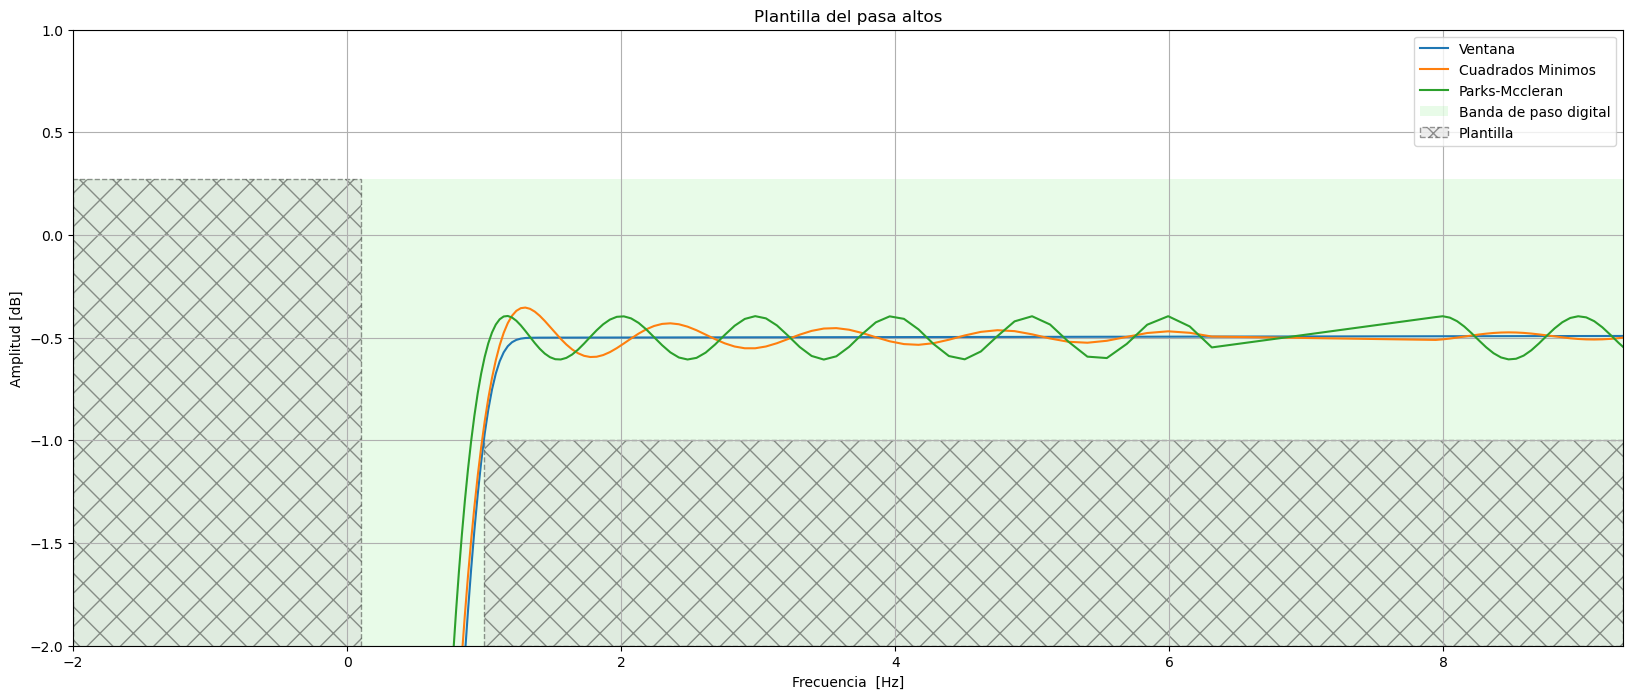

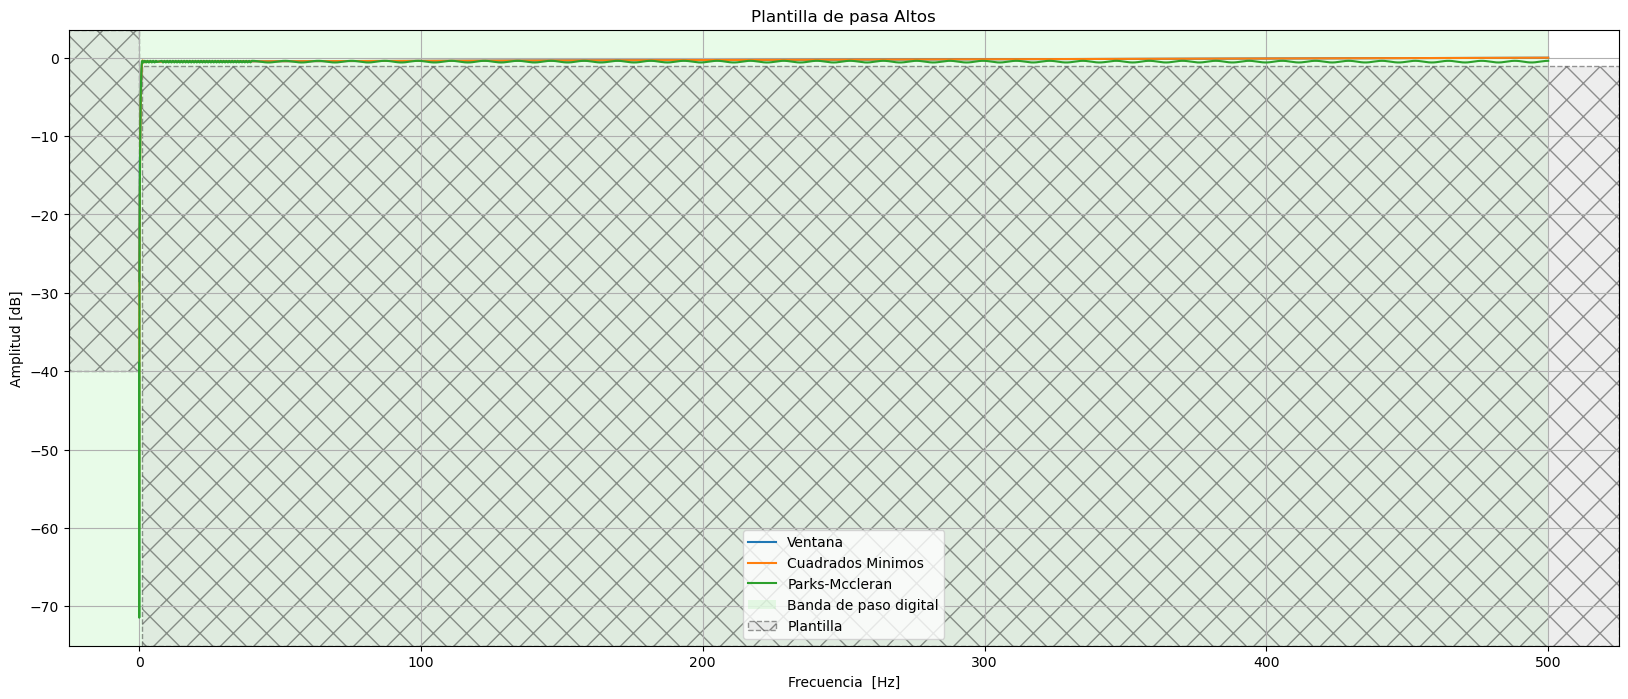

In [5]:
## Graficar los filtros Highpass
plt.figure(1,figsize=(20, 8))
plt.cla()

w_win , hh_win = sig.freqz(num_hp,1,worN=w_rad)
w_firls , hh_firls = sig.freqz(firls_hp,1,worN=w_rad)
w_remez , hh_remez = sig.freqz(remez_hp,1,worN=w_rad)


plt.plot(w_win/np.pi*f_nyq, 20*np.log10(np.abs(hh_win)+ 1e-15),label='Ventana') # Respuesta de Modulo Ventana
plt.plot(w_firls/np.pi*f_nyq, 20*np.log10(np.abs(hh_firls)+ 1e-15),label='Cuadrados Minimos') # Respuesta de Modulo Ventana
plt.plot(w_remez/np.pi*f_nyq, 20*np.log10(np.abs(hh_remez)+ 1e-15),label='Parks-Mccleran') # Respuesta de Modulo Ventana
plt.ylim(-2, 0.271)
plt.xlim(-2,9.31)
plt.title('Plantilla del pasa altos')
plt.xlabel('Frecuencia  [Hz]')
plt.ylabel('Amplitud [dB]')
plt.grid(which='both', axis='both')
plot_plantilla(filter_type = 'highpass' , fpass = fpass_hp, ripple = 1 , fstop = fstop_hp, attenuation = attenuation, fs = fs)
plt.legend()

plt.figure(2,figsize=(20, 8))
plt.cla()
plt.plot(w_win/np.pi*f_nyq, 20*np.log10(np.abs(hh_win)+ 1e-15),label='Ventana') # Respuesta de Modulo Ventana
plt.plot(w_firls/np.pi*f_nyq, 20*np.log10(np.abs(hh_firls)+ 1e-15),label='Cuadrados Minimos') # Respuesta de Modulo Ventana
plt.plot(w_remez/np.pi*f_nyq, 20*np.log10(np.abs(hh_remez)+ 1e-15),label='Parks-Mccleran') # Respuesta de Modulo Ventana
plt.title('Plantilla de pasa Altos')
plt.xlabel('Frecuencia  [Hz]')
plt.ylabel('Amplitud [dB]')
plt.grid(which='both', axis='both')
plot_plantilla(filter_type = 'highpass' , fpass = fpass_hp, ripple = 1 , fstop = fstop_hp, attenuation = attenuation, fs = fs)
plt.legend()


Se puede ver como con los coeficientes propuestos las respeusta al impulso cumple la exigencia del ancho de banda, se ve como el metodo de ventanas, ademas de estar sobre exigido, costo un poco mas adaptarlo. Vemos tambien como el PM sigue la tendencia equiripple en toda la banda de paso y que Cuadrados minimos tambien se pudo adaptar al comportamiento esperado,siendo este mejor que PM ya que posee una cantidad de coeficientes inferior a este 

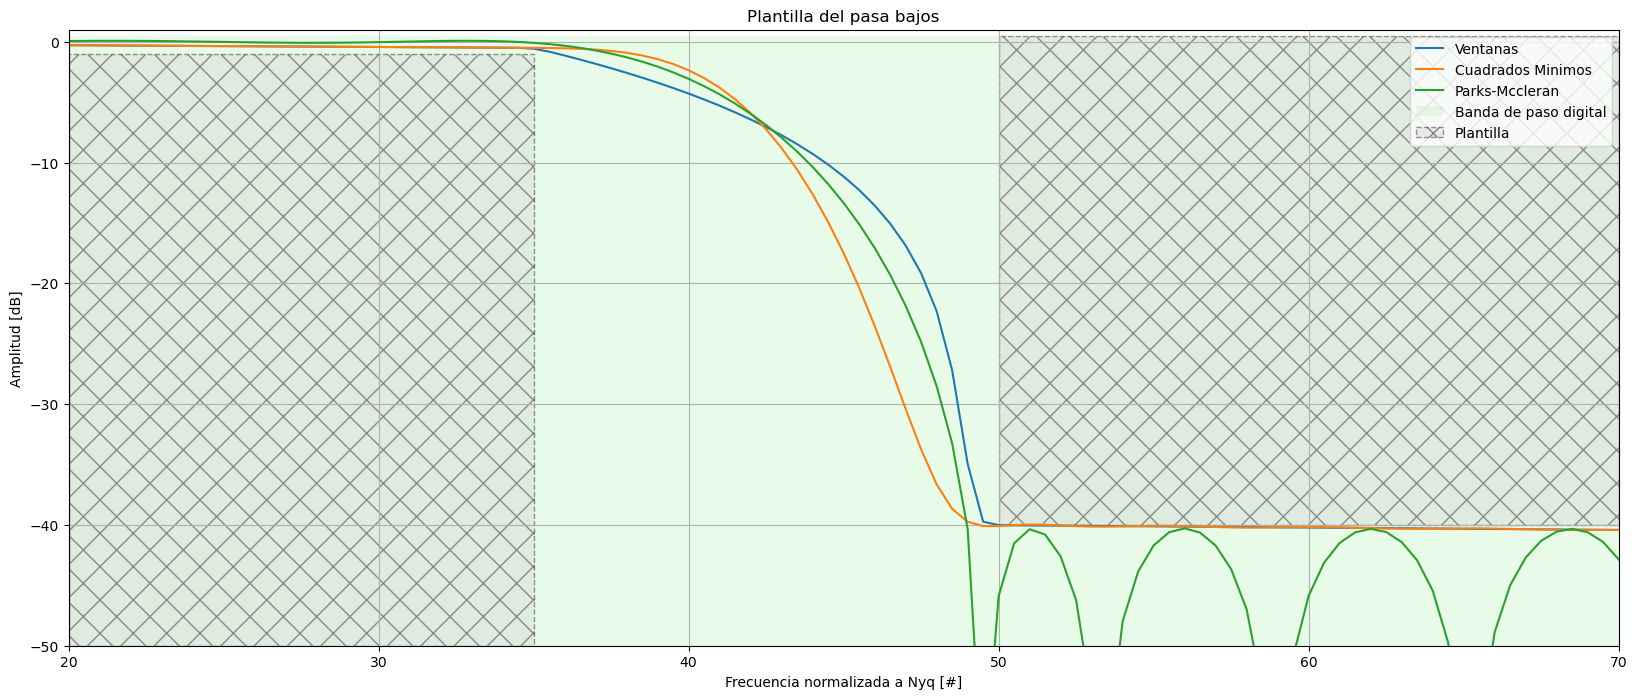

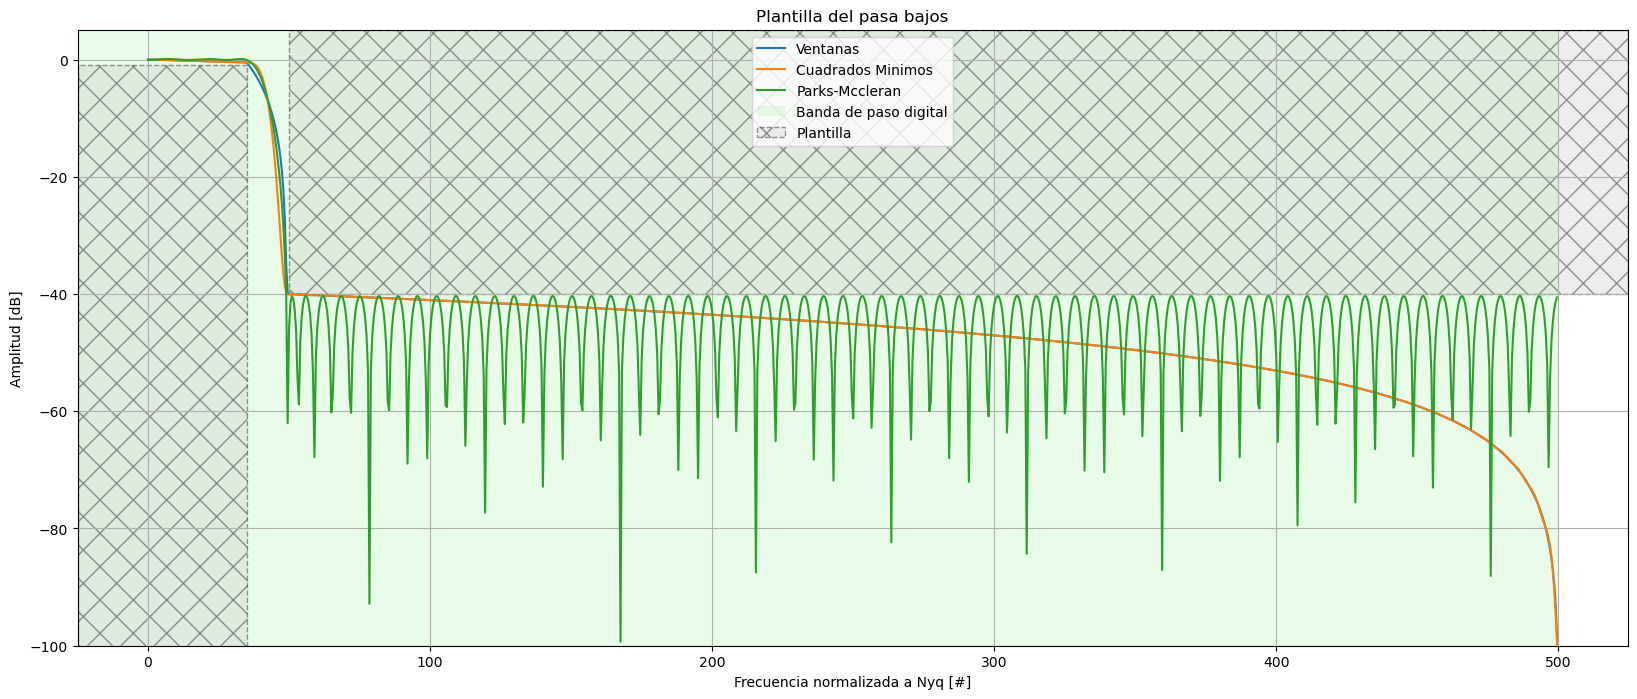

In [6]:
## Graficar los filtros Lowpass
plt.figure(4,figsize=(20, 8))
plt.cla()

w_win , hh_win = sig.freqz(num_lp,1,worN=1000)
w_firls , hh_firls = sig.freqz(firls_lp,1,worN=1000)
w_remez , hh_remez = sig.freqz(remez_lp,1,worN=1000)

plt.plot(w_win/np.pi*f_nyq, 20*np.log10(np.abs(hh_win)+ 1e-15),label='Ventanas') # Respuesta de Modulo
plt.plot(w_firls/np.pi*f_nyq, 20*np.log10(np.abs(hh_firls)+ 1e-15),label='Cuadrados Minimos') # Respuesta de Modulo
plt.plot(w_remez/np.pi*f_nyq, 20*np.log10(np.abs(hh_remez)+ 1e-15),label='Parks-Mccleran') # Respuesta de Modulo
plt.ylim(-50, 0.5)
plt.xlim(20,70)
plt.title('Plantilla del pasa bajos')
plt.xlabel('Frecuencia normalizada a Nyq [#]')
plt.ylabel('Amplitud [dB]')
plt.grid(which='both', axis='both')
plot_plantilla(filter_type = 'lowpass' , fpass = fpass_lp, ripple = 1 , fstop = 50, attenuation = attenuation, fs = fs)
plt.legend()

plt.figure(5,figsize=(20, 8))
plt.cla()
plt.plot(w_win/np.pi*f_nyq, 20*np.log10(np.abs(hh_win)+ 1e-15),label='Ventanas') # Respuesta de Modulo
plt.plot(w_firls/np.pi*f_nyq, 20*np.log10(np.abs(hh_firls)+ 1e-15),label='Cuadrados Minimos') # Respuesta de Modulo
plt.plot(w_remez/np.pi*f_nyq, 20*np.log10(np.abs(hh_remez)+ 1e-15),label='Parks-Mccleran') # Respuesta de Modulo
plt.title('Plantilla del pasa bajos')
plt.xlabel('Frecuencia normalizada a Nyq [#]')
plt.ylabel('Amplitud [dB]')
plt.grid(which='both', axis='both')
plot_plantilla(filter_type = 'lowpass' , fpass = fpass_lp, ripple = 1 , fstop = 50, attenuation = attenuation, fs = fs)
plt.legend()


En el caso del filtro pasa altos, tanto para ventanas y cuadrados minimos, sin exigir tanto los coeficientes y el algoritmo, se puede cumplir con los requisitos de la plantilla. Ademas de que en PM  se nota la tendencia equiripple mencionada previamente en la explicacion del metodo, que converge para la banda de atenuacion en todo Nyquist.

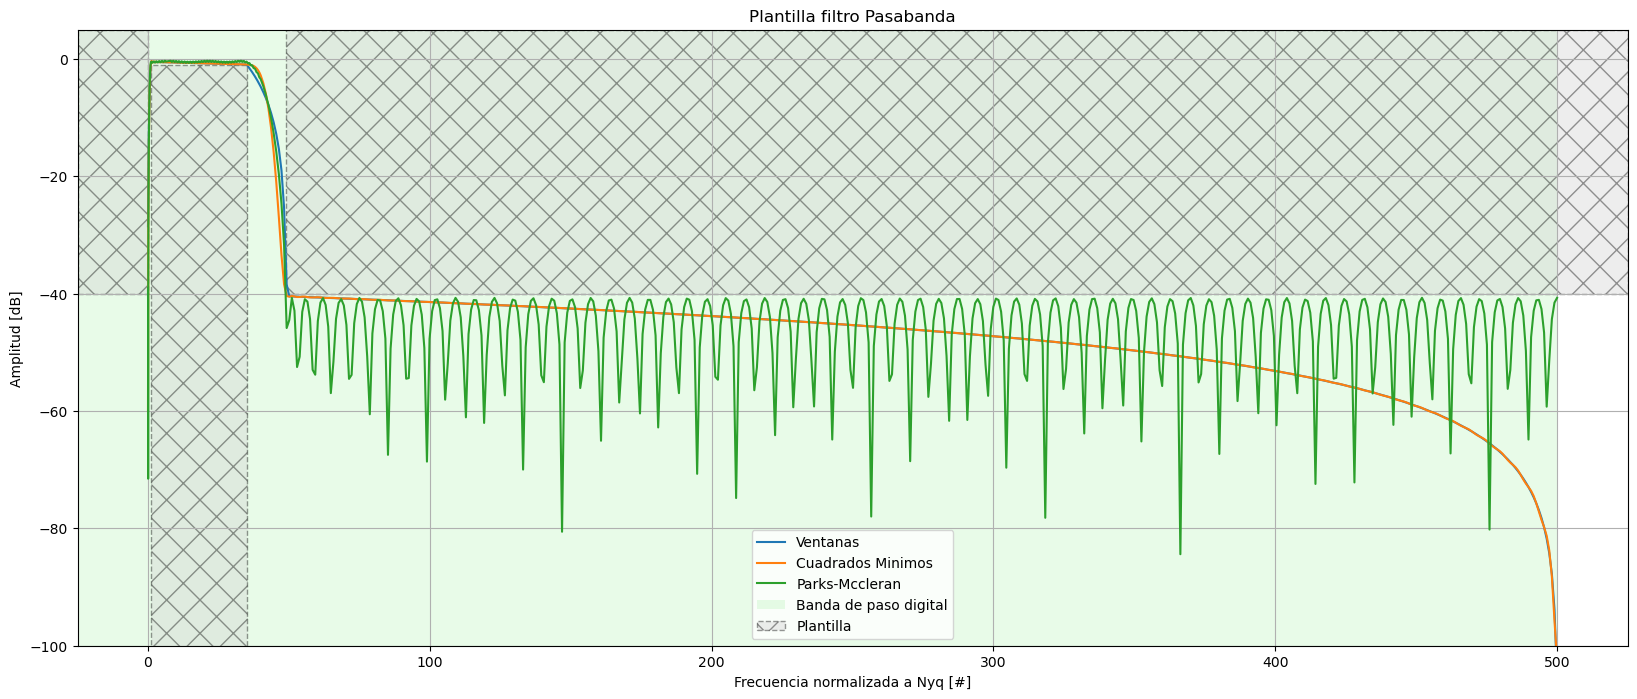

In [7]:
# %% Grafico de pasabanda Metodo de Ventanas
num_bp = np.convolve(num_hp, num_lp)
firls_bp = np.convolve(firls_hp, firls_lp)
remez_bp = np.convolve(remez_hp, remez_lp)

fpass_bp = np.array([fpass_hp , fpass_lp]) 
fstop_bp = np.array([fstop_hp , fstop_lp])
plt.figure(7,figsize=(20, 8))
plt.cla()

w_win , hh_win = sig.freqz(num_bp,1,worN=w_rad)
w_firls , hh_firls = sig.freqz(firls_bp,1,worN=w_rad)
w_remez , hh_remez = sig.freqz(remez_bp,1,worN=w_rad)

plt.plot(w_win/np.pi*f_nyq, 20*np.log10(np.abs(hh_win)+ 1e-15),label='Ventanas') # Respuesta de Modulo
plt.plot(w_firls/np.pi*f_nyq, 20*np.log10(np.abs(hh_firls)+ 1e-15),label='Cuadrados Minimos') # Respuesta de Modulo
plt.plot(w_remez/np.pi*f_nyq, 20*np.log10(np.abs(hh_remez)+ 1e-15),label='Parks-Mccleran') # Respuesta de Modulo
plt.title('Plantilla filtro Pasabanda')
plt.xlabel('Frecuencia normalizada a Nyq [#]')
plt.ylabel('Amplitud [dB]')
plt.grid(which='both', axis='both')
plot_plantilla(filter_type = 'bandpass' , fpass = fpass_bp, ripple = 1 , fstop = fstop_bp, attenuation = attenuation, fs = fs)
plt.legend()


Por ultimo se observa la convolucion de los dos filtros, culminando asi en un pasabanda.

Como se dijo previamente los filtros FIR son lineales :

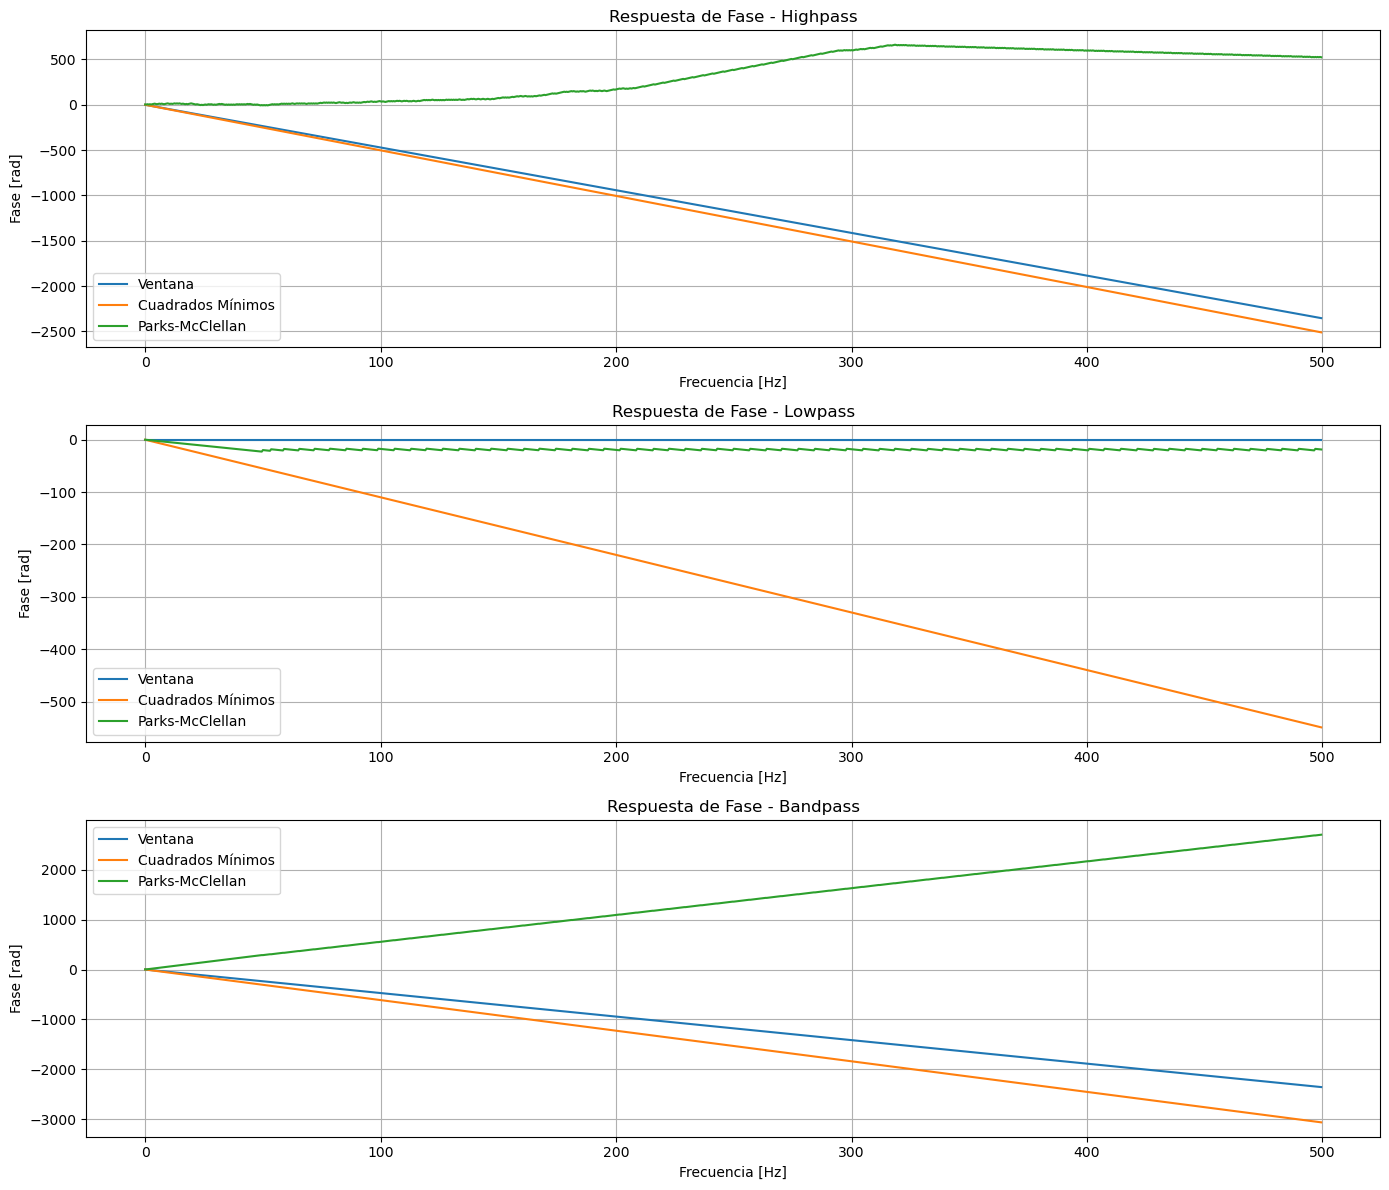

In [28]:
# Graficar la respuesta de fase de los filtros Highpass, Lowpass y Bandpass (uno debajo del otro)

plt.figure(figsize=(14, 12))

# --- Highpass ---
plt.subplot(3, 1, 1)
w_win, hh_win = sig.freqz(num_hp,1, worN=1000)
w_firls, hh_firls = sig.freqz(firls_hp,1, worN=1000)
w_remez, hh_remez = sig.freqz(remez_hp,1, worN=1000)
hh_win = np.unwrap(np.angle(hh_win))
hh_firls = np.unwrap(np.angle(hh_firls))
hh_remez = np.unwrap(np.angle(hh_remez))
plt.plot(w_win/np.pi*f_nyq,hh_win, label='Ventana')
plt.plot(w_firls/np.pi*f_nyq, hh_firls, label='Cuadrados Mínimos')
plt.plot(w_remez/np.pi*f_nyq, hh_remez, label='Parks-McClellan')
plt.title('Respuesta de Fase - Highpass')
plt.xlabel('Frecuencia [Hz]')
plt.ylabel('Fase [rad]')
plt.grid()
plt.legend()

# --- Lowpass ---
plt.subplot(3, 1, 2)
w_win, hh_win = sig.freqz(num_lp,1, worN=1000)
w_firls, hh_firls = sig.freqz(firls_lp,1, worN=1000)
w_remez, hh_remez = sig.freqz(remez_lp,1, worN=1000)
plt.plot(w_win/np.pi*f_nyq, np.unwrap(np.angle(hh_win)), label='Ventana')
plt.plot(w_firls/np.pi*f_nyq, np.unwrap(np.angle(hh_firls)), label='Cuadrados Mínimos')
plt.plot(w_remez/np.pi*f_nyq, np.unwrap(np.angle(hh_remez)), label='Parks-McClellan')
plt.title('Respuesta de Fase - Lowpass')
plt.xlabel('Frecuencia [Hz]')
plt.ylabel('Fase [rad]')
plt.grid()
plt.legend()

# --- Bandpass ---
plt.subplot(3, 1, 3)
w_win, hh_win = sig.freqz(num_bp,1, worN=1000)
w_firls, hh_firls = sig.freqz(firls_bp,1, worN=1000)
w_remez, hh_remez = sig.freqz(remez_bp,1, worN=1000)
plt.plot(w_win/np.pi*f_nyq, np.unwrap(np.angle(hh_win)), label='Ventana')
plt.plot(w_firls/np.pi*f_nyq, np.unwrap(np.angle(hh_firls)), label='Cuadrados Mínimos')
plt.plot(w_remez/np.pi*f_nyq, np.unwrap(np.angle(hh_remez)), label='Parks-McClellan')
plt.title('Respuesta de Fase - Bandpass')
plt.xlabel('Frecuencia [Hz]')
plt.ylabel('Fase [rad]')
plt.grid()
plt.legend()

plt.tight_layout()
plt.show()

Analisis de la respuesta de fase: Primero con respecto al High-pass podemos observar la tendencia lineal en el metodo de Ventana y LS, para PM notamos que presenta un comportamiento extraño a lo esperado (No se bien por que y no termina de ser elocuente). Luego en el pasabajo vemos como en el PM sigue un comportamiento esperado al tener un ripple despues de los 50 HZ, en Ventanas no comprendo la razon de ese comportamieno constante y esta teniendo como pequeñas oscilaciones, por ultimo el que tiene una respuesta esperada es el de Caudrado Minimos. 
En los pasabanda el comportamiento del LS y ventanas corresponde al tipo de filtro, lo que le ocurre al PM se lo puede adjudicar al pasa altos.

# Infinite Impulse Response (IIR)

Estos son la contra parte de los FIR, donde estos tienen una respuesta de fase no lineal e inestabiladad y son recursivos. Ademas de que requiere poco costo computacion para su implementacion y presentan mas sensibilidad a los coeficientes de cuantizacion y ruido.
Los IIR son filtros causales donde su ecuacion esta definida por :
$$
\sum_{k=0}^{N} a_k y[n-k] = \sum_{k=0}^{M} b_k x[n-k],
$$
Si reacomodamos se tiene :
$$
y[n] = \sum_{k=0}^{M} b_k x[n-k] - \sum_{k=1}^{N} a_k y[n-k].
$$

Diferenciandose de los FIR, estos filtros al momento de aplicar la transformada Z, no solamente tienen ceros en el origen si no que pueden estar localziados por el plano complejo z, es el motivo principal de su inestabilidad.

-Filtro De maxima planicidad o Butterworth : se define por la siguiente funcion 
$$
|H(\Omega)| = \frac{1}{\sqrt{1 + (\Omega/\Omega_c)^{2N}}}. \
$$
En donde $N$ es el orden del filtro y $\Omega_c$ es la frecuencia de corte, donde se nota que $H(0)=1$ y decrece con el incremento de la frecuencia para cada valor de N. Por esta razon se dice que es de maxima planicidad, ya que vale 1 para la banda de paso y de stop.

-Filtro de Chenyshev Tipo II : definido como 
$$
|H(\Omega)| = \frac{1}{\sqrt{1 + \varepsilon_s^2 T_N^{-2}(\Omega_e/\Omega)}},
$$

en donde $\varepsilon_s^2$ es el ripple de la banda de stop, $N$ este vuelve a ser el orden del filtro y $\Omega_s$ la frecuencia de corte. Al no tener una variacion del ripple en la banda de paso, genera un comportamiento de maxima planicidad y justamente un ripple en la banda de stop, que su magnitud va ser la misma que la atenuacion que se busca en esa banda.

-Filtro elliptic: Su formula esta dada por 
$$
|H(\Omega)| = \frac{1}{\sqrt{1 + \varepsilon_\rho^2 R_N^2(\xi, \Omega/\Omega_c)}},
$$

Con $R_N^2(\xi, \Omega/\Omega_c)$ siendo esta llamada "elliptic rational function". A diferencia de otros filtros estos dependen de 4 parametros: el oreden del filtro $N$, la frecuencia de corte $Omega_c$, el factor del ripple en el pasa badna $\varepsilon_\rho$ y el facgtor de selectividad $\xi$,
Este tipo de filtrado presenta un equiripple en ambas bandas, siendo estas independientes entre ellas. Lo que tiene de caracteriztico este filtro es que presenta una banda de transicion mas abrupta que depende del orden de coeficiente.

A continuacion se diseñaran las plantillas con los metodos explicados previamente.

In [9]:
# Bandpass
fpass = np.array( [1, 35] ) 
ripple = 1.0 # dB
fstop = np.array( [0.1, 50] ) 
attenuation = 40.0 # dB

my_sos_1 = sig.iirdesign(fpass, fstop, ripple, attenuation,fs=fs,ftype='cheby2',output='sos')
my_sos_2 = sig.iirdesign(fpass, fstop, ripple, attenuation,fs=fs,ftype='ellip',output='sos')
my_sos_3 = sig.iirdesign(fpass, fstop, ripple, attenuation,fs=fs,ftype='butter',output='sos')

w_rad = np.append(np.logspace(-2,0.8,250), np.logspace(0.9,1.6,250))
w_rad = np.append(w_rad, np.linspace(40,f_nyq,500,endpoint=True))/f_nyq * np.pi

In [10]:

# Butterworth
df_butter = pd.DataFrame(my_sos_3, columns=['b0', 'b1', 'b2', 'a0', 'a1', 'a2'])
display(df_butter.style.format("{:.6f}").set_caption("Coeficientes del filtro Butterworth (SOS)"))


La funcion iirdesing devuelve una matriz de coeficientes de segundo orden, estos son implementados en forma de cascada, llegando a obtener en este caso $15(filas) . 2$ coeficientes --> 28

In [11]:
# Chebyshev II
df_cheby2 = pd.DataFrame(my_sos_1, columns=['b0', 'b1', 'b2', 'a0', 'a1', 'a2'])
display(df_cheby2.style.format("{:.6f}").set_caption("Coeficientes del filtro Chebyshev II (SOS)"))


Se puede ver como para este metodo se requiere pocos coeficientes para llegar a la plantilla deseada, en comparacion con butterworth que exige mucho mas al querer siempre llegar a la maxima planicidad

In [12]:
# Elíptico
df_ellip = pd.DataFrame(my_sos_2, columns=['b0', 'b1', 'b2', 'a0', 'a1', 'a2'])
display(df_ellip.style.format("{:.6f}").set_caption("Coeficientes del filtro Elíptico (SOS)"))

Por ultimo el elipptic usa 2 filas menos de coeficientes en lo que corresponde al metodo mencionado anteriormente. Justamente al ser equiripple en ambas bandas, solo hay exigencia en las transiciones.

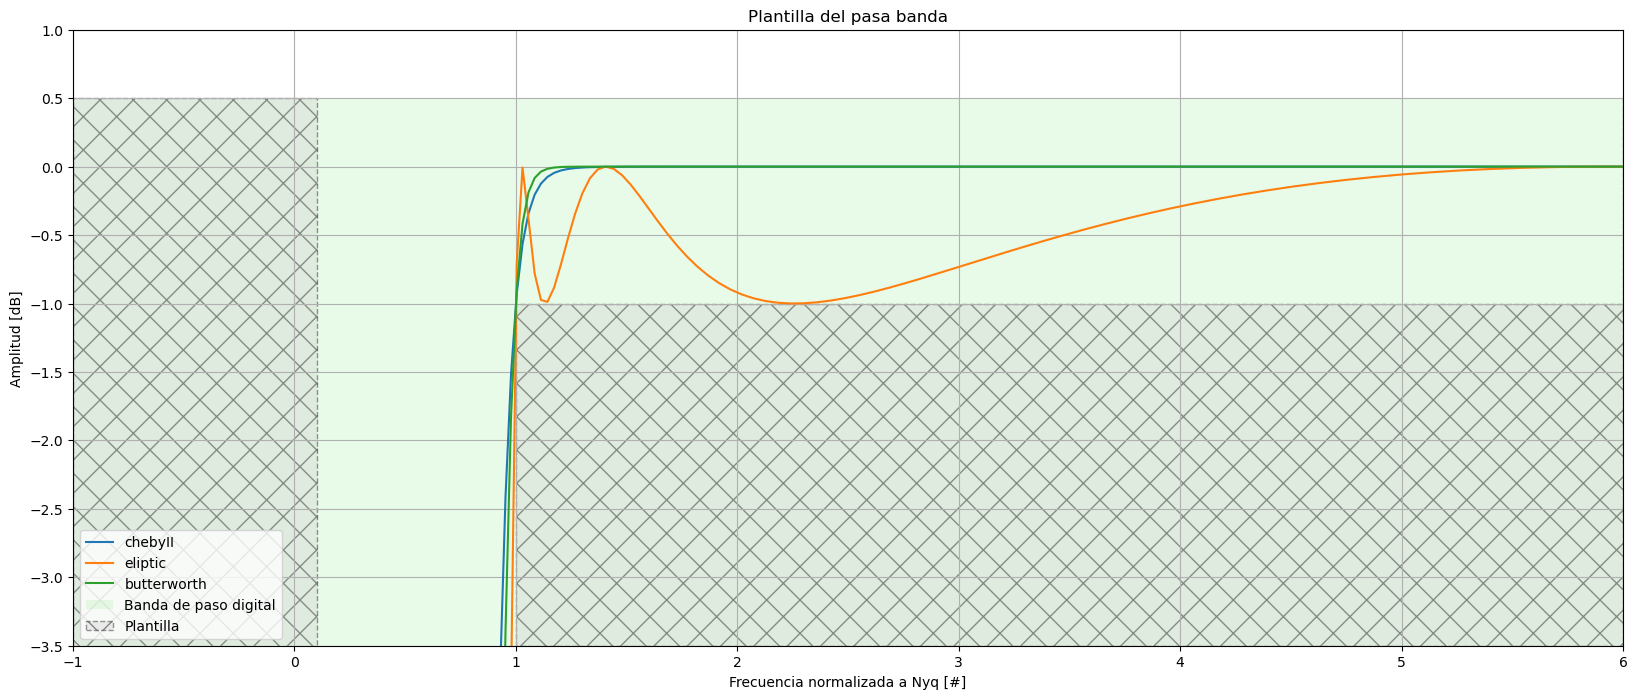

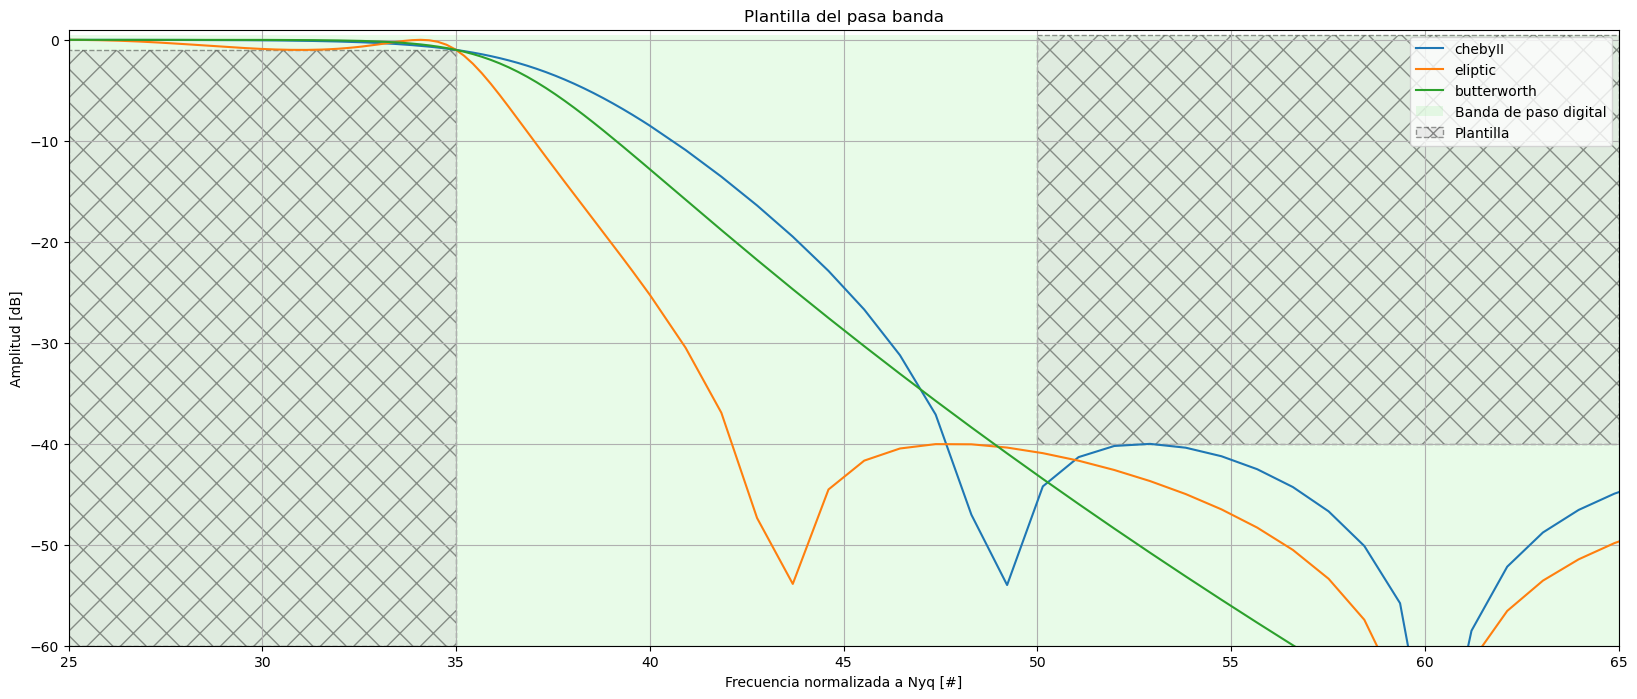

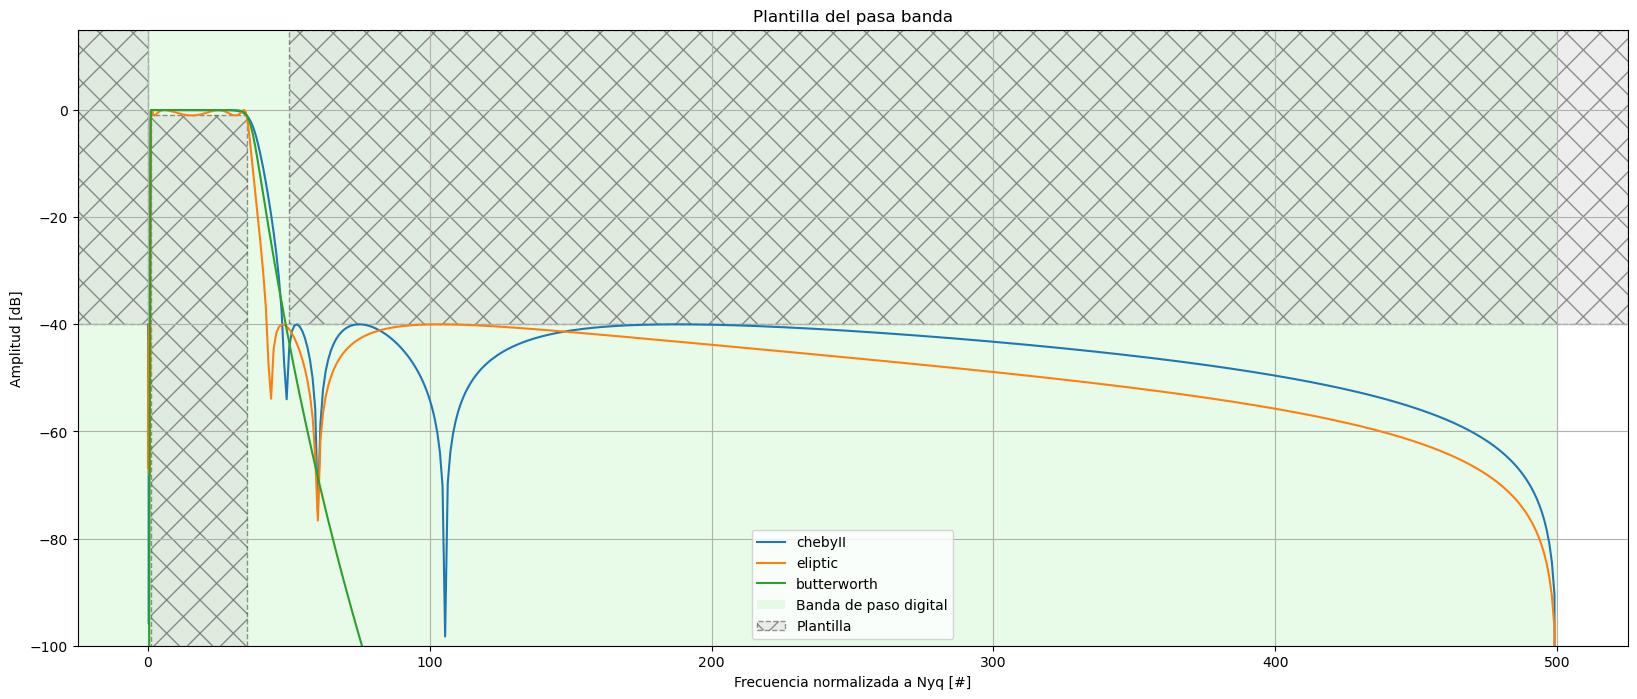

In [13]:
w_1 , hh_1 = sig.sosfreqz(my_sos_1,worN=w_rad)
w_2 , hh_2 = sig.sosfreqz(my_sos_2,worN=w_rad)
w_3 , hh_3 = sig.sosfreqz(my_sos_3,worN=w_rad)

phase_1 = np.unwrap(np.angle(hh_1))
phase_2 = np.unwrap(np.angle(hh_2))
phase_3 = np.unwrap(np.angle(hh_3))

plt.figure(1,figsize=(20, 8))
plt.cla()

plt.plot(w_1/np.pi*f_nyq, 20*np.log10(np.abs(hh_1)+ 1e-15),label='chebyII') # Respuesta de Modulo
plt.plot(w_2/np.pi*f_nyq, 20*np.log10(np.abs(hh_2)+ 1e-15),label='eliptic') # Respuesta de Modulo
plt.plot(w_3/np.pi*f_nyq, 20*np.log10(np.abs(hh_3)+ 1e-15),label='butterworth') # Respuesta de Modulo
plt.ylim(-3.5, 0.5)
plt.xlim(-1,6)

plt.title('Plantilla del pasa banda')
plt.xlabel('Frecuencia normalizada a Nyq [#]')
plt.ylabel('Amplitud [dB]')
plt.grid(which='both', axis='both')
plot_plantilla(filter_type = 'bandpass' , fpass = fpass, ripple = ripple , fstop = fstop, attenuation = attenuation, fs = fs)
plt.legend()

plt.figure(2,figsize=(20, 8))
plt.cla()

plt.plot(w_1/np.pi*f_nyq, 20*np.log10(np.abs(hh_1)+ 1e-15),label='chebyII') # Respuesta de Modulo
plt.plot(w_2/np.pi*f_nyq, 20*np.log10(np.abs(hh_2)+ 1e-15),label='eliptic') # Respuesta de Modulo
plt.plot(w_3/np.pi*f_nyq, 20*np.log10(np.abs(hh_3)+ 1e-15),label='butterworth') # Respuesta de Modulo
plt.ylim(-60, 0.5)
plt.xlim(25,65)
plt.title('Plantilla del pasa banda')
plt.xlabel('Frecuencia normalizada a Nyq [#]')
plt.ylabel('Amplitud [dB]')
plt.grid(which='both', axis='both')
plot_plantilla(filter_type = 'bandpass' , fpass = fpass, ripple = ripple , fstop = fstop, attenuation = attenuation, fs = fs)
plt.legend()

plt.figure(3,figsize=(20, 8))
plt.cla()

plt.plot(w_1/np.pi*f_nyq, 20*np.log10(np.abs(hh_1)+ 1e-15),label='chebyII') # Respuesta de Modulo
plt.plot(w_2/np.pi*f_nyq, 20*np.log10(np.abs(hh_2)+ 1e-15),label='eliptic') # Respuesta de Modulo
plt.plot(w_3/np.pi*f_nyq, 20*np.log10(np.abs(hh_3)+ 1e-15),label='butterworth') # Respuesta de Modulo
plt.title('Plantilla del pasa banda')
plt.xlabel('Frecuencia normalizada a Nyq [#]')
plt.ylabel('Amplitud [dB]')
plt.grid(which='both', axis='both')
plot_plantilla(filter_type = 'bandpass' , fpass = fpass, ripple = ripple , fstop = fstop, attenuation = attenuation, fs = fs)
plt.legend()



Como era de esperarse los coeficientes cumplen con el filtro establecido, se puede notar tambien como la de butterworth no presenta ripple en ningun momento, en cambio como se habia mencionado anteriormente en cheby II y eliptic van a presentar un ripple en la banda de stop, este al ser de pocos coeficiente no presenta tantas oscilaciones, este ultimo filtro tambien presenta oscilaciones en la frecuenca de paso, lo cual era esperable.

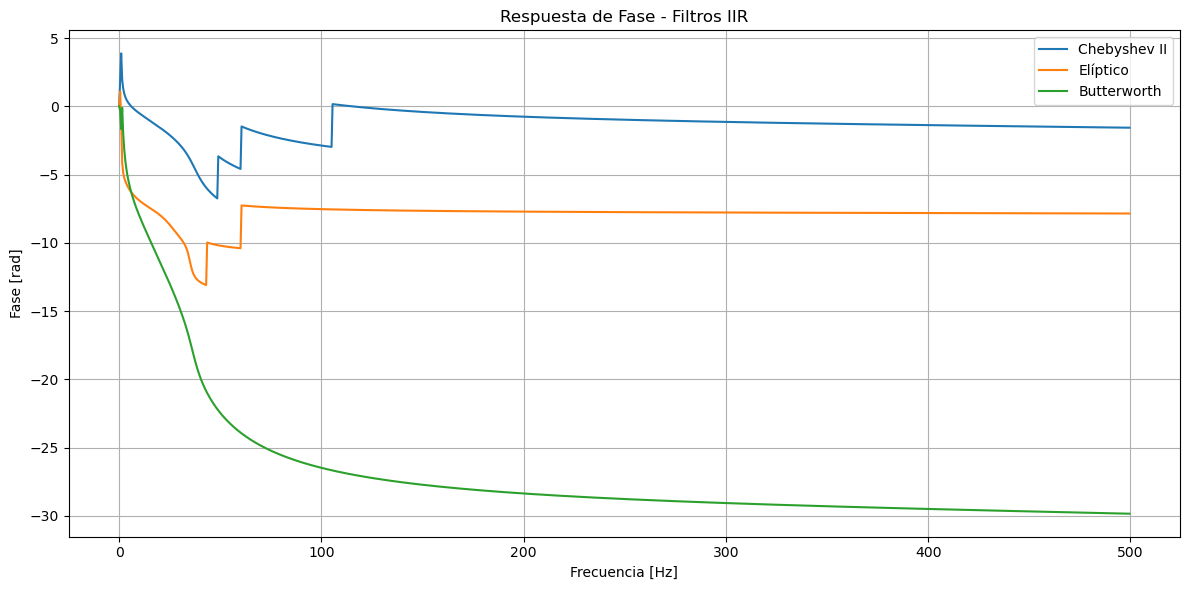

In [14]:
w_1, hh_1 = sig.sosfreqz(my_sos_1, worN=1000)
w_2, hh_2 = sig.sosfreqz(my_sos_2, worN=1000)
w_3, hh_3 = sig.sosfreqz(my_sos_3, worN=1000)

plt.figure(figsize=(12, 6))
plt.plot(w_1/np.pi*f_nyq, np.unwrap(np.angle(hh_1)), label='Chebyshev II')
plt.plot(w_2/np.pi*f_nyq, np.unwrap(np.angle(hh_2)), label='Elíptico')
plt.plot(w_3/np.pi*f_nyq, np.unwrap(np.angle(hh_3)), label='Butterworth')
plt.title('Respuesta de Fase - Filtros IIR')
plt.xlabel('Frecuencia [Hz]')
plt.ylabel('Fase [rad]')
plt.grid()
plt.legend()
plt.tight_layout()
plt.show()

Como era de esperarse la respuesta de fase de los fitros IIR son no lineales.

In [15]:
## Filtrado de las señales

f_ecg_win=sig.lfilter(num_bp,1,ecg_one_lead,axis=0) # FIR con Metodo de Ventanas
f_ecg_firls=sig.lfilter(firls_bp,1,ecg_one_lead,axis=0) # FIR con Metodo de Cuadrados Minimos
f_ecg_remez=sig.lfilter(remez_bp,1,ecg_one_lead,axis=0) # FIR con Metodo de Parks-McCleran
f_ecg_cheby2=sig.sosfiltfilt(my_sos_1,ecg_one_lead,axis=0) # IIR con Chebyshev II
f_ecg_ellip=sig.sosfiltfilt(my_sos_2,ecg_one_lead,axis=0) # IIR con Eliptico
f_ecg_butter=sig.sosfiltfilt(my_sos_3,ecg_one_lead,axis=0) # IIR con Butterworth


In [16]:
def plot_ecg_filtered(ecg_one_lead,f_ecg, cant_muestras,demora,nombre_filtro):
    ###################################
#%% Regiones de interés con ruido #
###################################
 
    regs_interes = (
            [4000, 5500], # muestras
            [10e3, 11e3], # muestras
            )
    
    for ii in regs_interes:
    
        # intervalo limitado de 0 a cant_muestras
        zoom_region = np.arange(np.max([0, ii[0]]), np.min([cant_muestras, ii[1]]), dtype='uint')
    
        plt.figure(1,figsize=(20,8))
        plt.plot(zoom_region, ecg_one_lead[zoom_region], label='ECG', linewidth=2)
        plt.plot(zoom_region, f_ecg[zoom_region + demora], label=nombre_filtro)
    
        plt.title('ECG Filtro ' + nombre_filtro + ' de ' + str(ii[0]) + ' a ' + str(ii[1]))
        plt.ylabel('Adimensional')
        plt.xlabel('Muestras (#)')
    
        axes_hdl = plt.gca()
        axes_hdl.legend()
        axes_hdl.set_yticks(())
            
        plt.show()
    
    ###################################
    #%% Regiones de interés sin ruido #
    ###################################
    
    regs_interes = (
            np.array([5, 5.2]) *60*fs, # minutos a muestras
            np.array([12, 12.4]) *60*fs, # minutos a muestras
            np.array([15, 15.2]) *60*fs, # minutos a muestras
            )
    
    for ii in regs_interes:
    
        # intervalo limitado de 0 a cant_muestras
        zoom_region = np.arange(np.max([0, ii[0]]), np.min([cant_muestras, ii[1]]), dtype='uint')
    
        plt.figure(2,figsize=(20,8))
        plt.plot(zoom_region, ecg_one_lead[zoom_region], label='ECG', linewidth=2)
        plt.plot(zoom_region, f_ecg[zoom_region + demora], label=nombre_filtro)
    
        plt.title('ECG Filtro ' + nombre_filtro + ' de ' + str(ii[0]) + ' a ' + str(ii[1]))
        plt.ylabel('Adimensional')
        plt.xlabel('Muestras (#)')
    
        axes_hdl = plt.gca()
        axes_hdl.legend()
        axes_hdl.set_yticks(())
            
        plt.show()
    return 


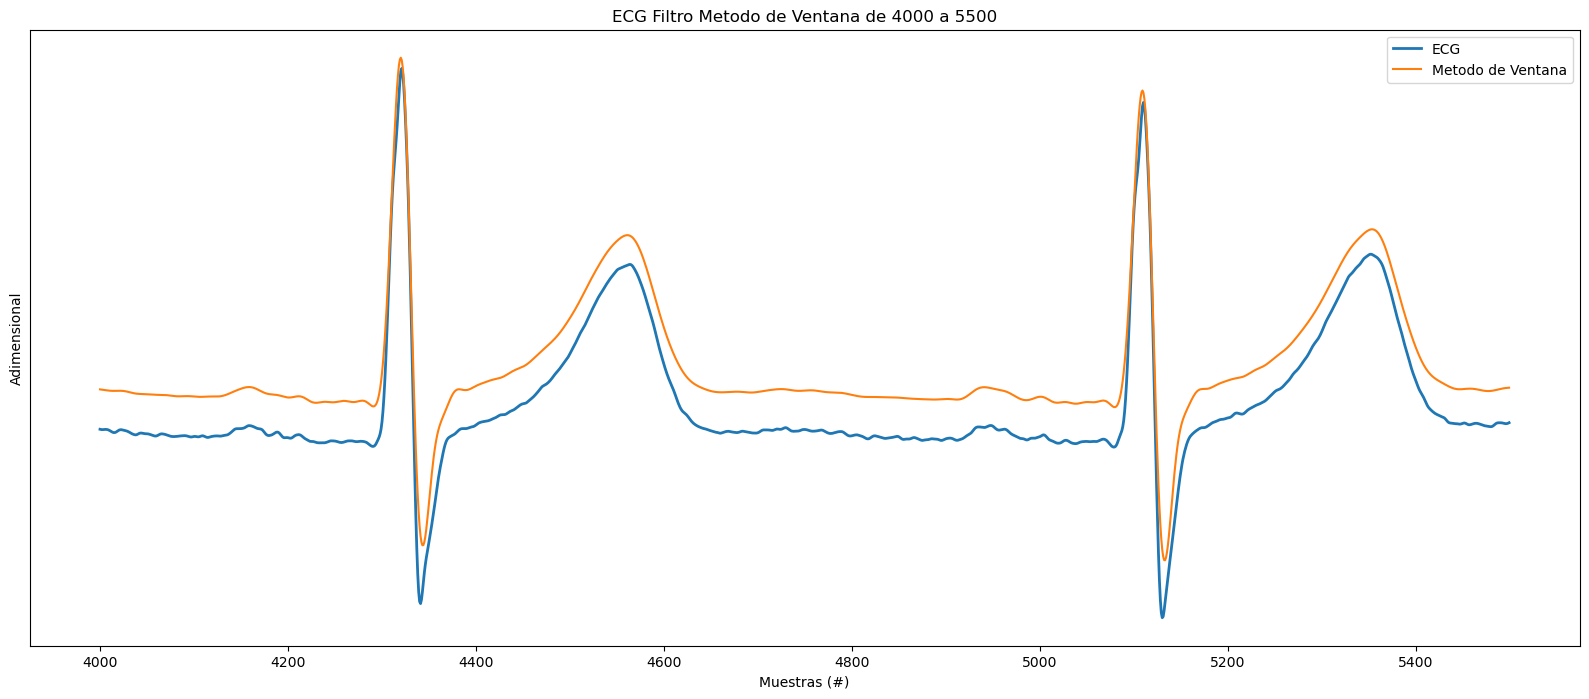

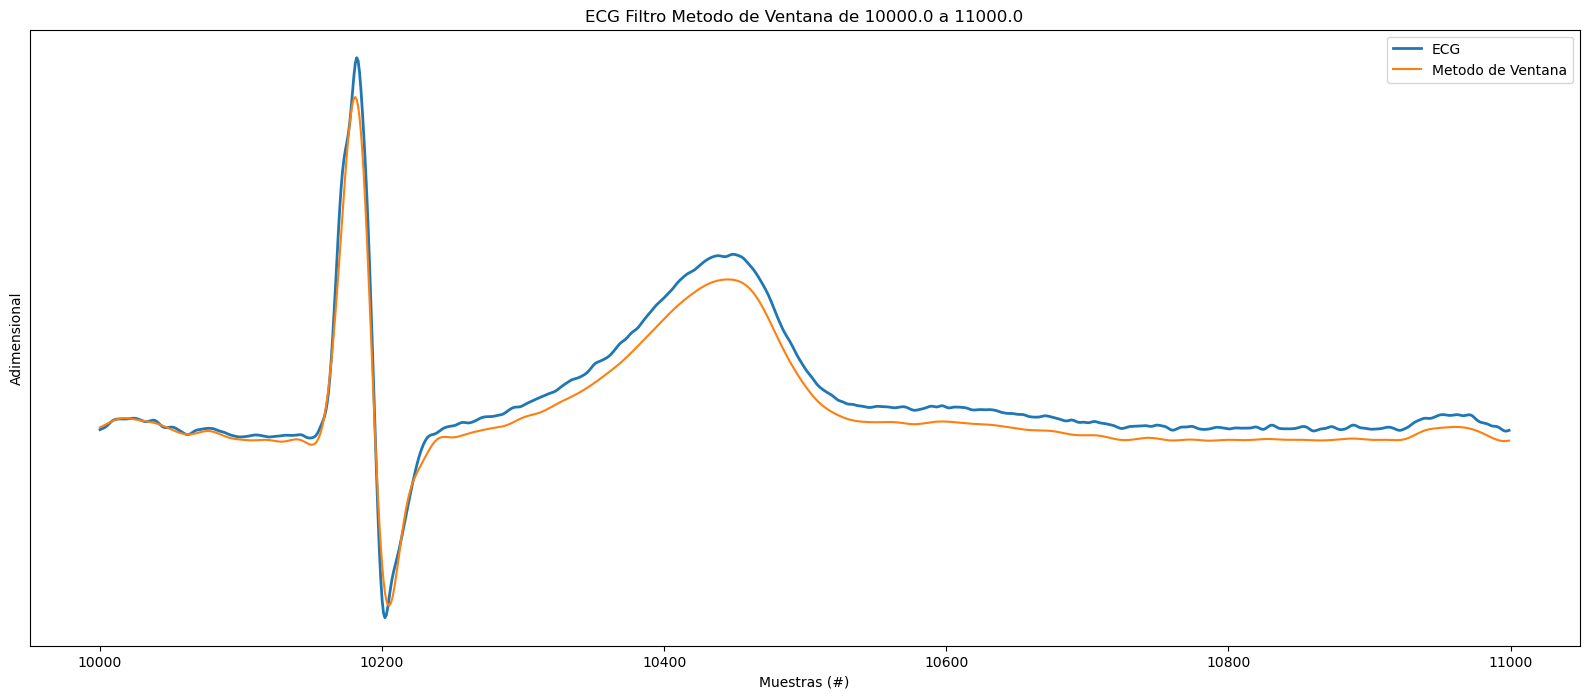

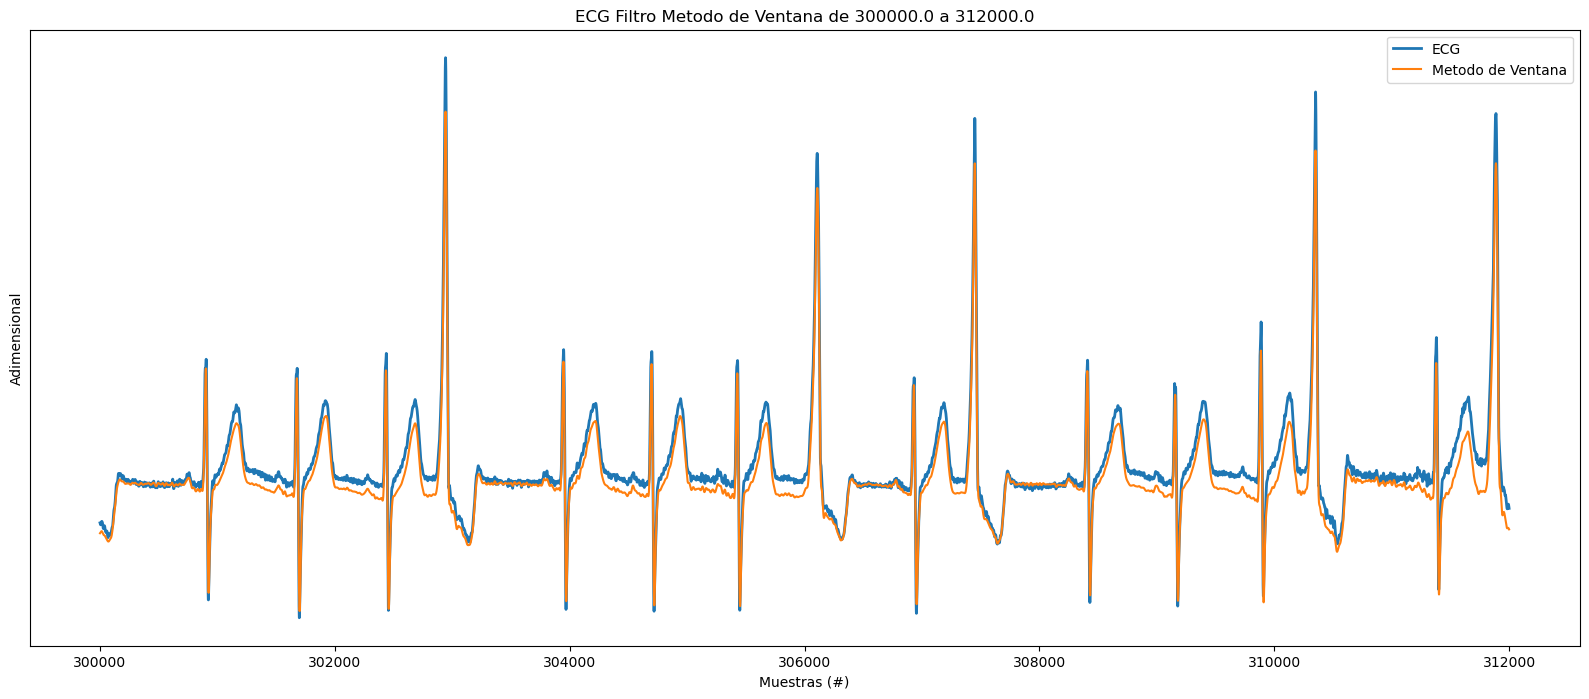

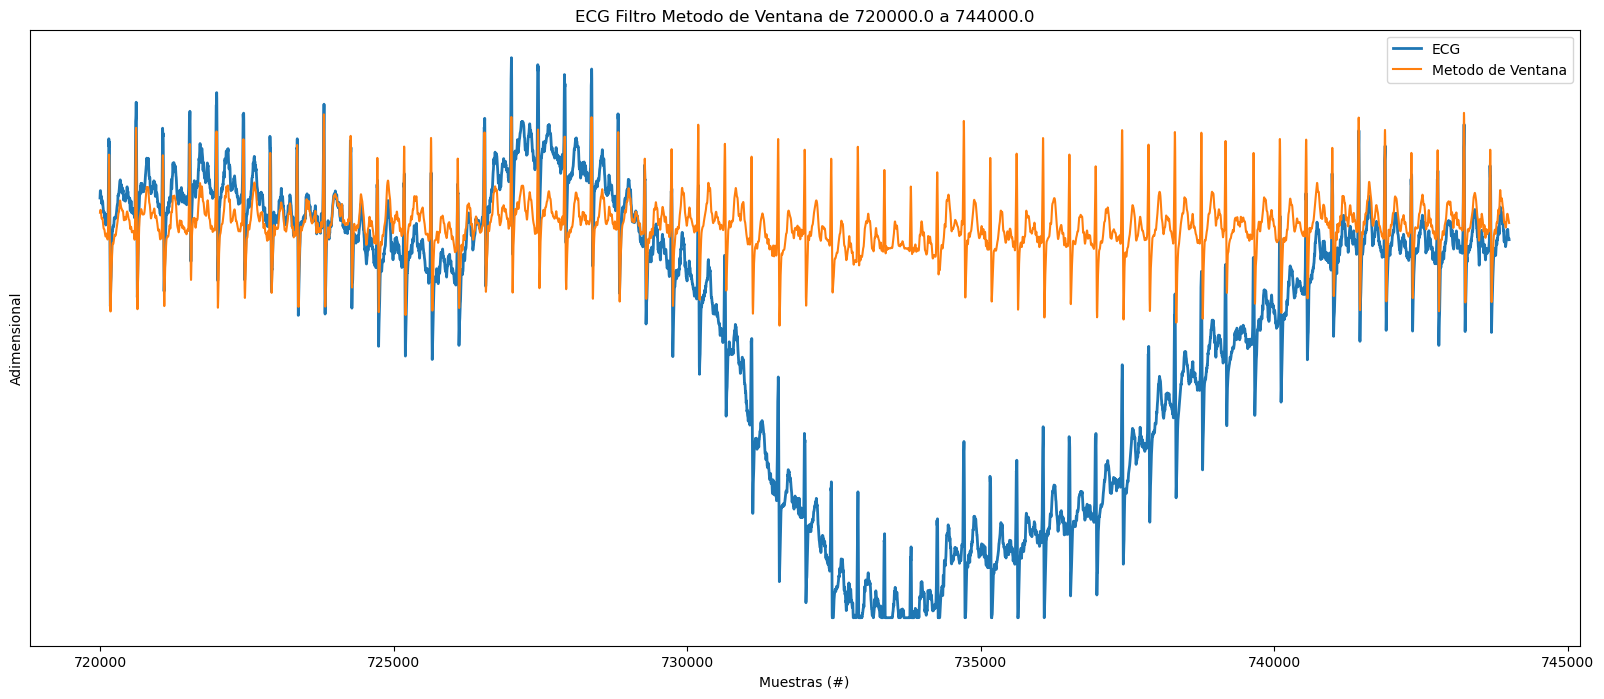

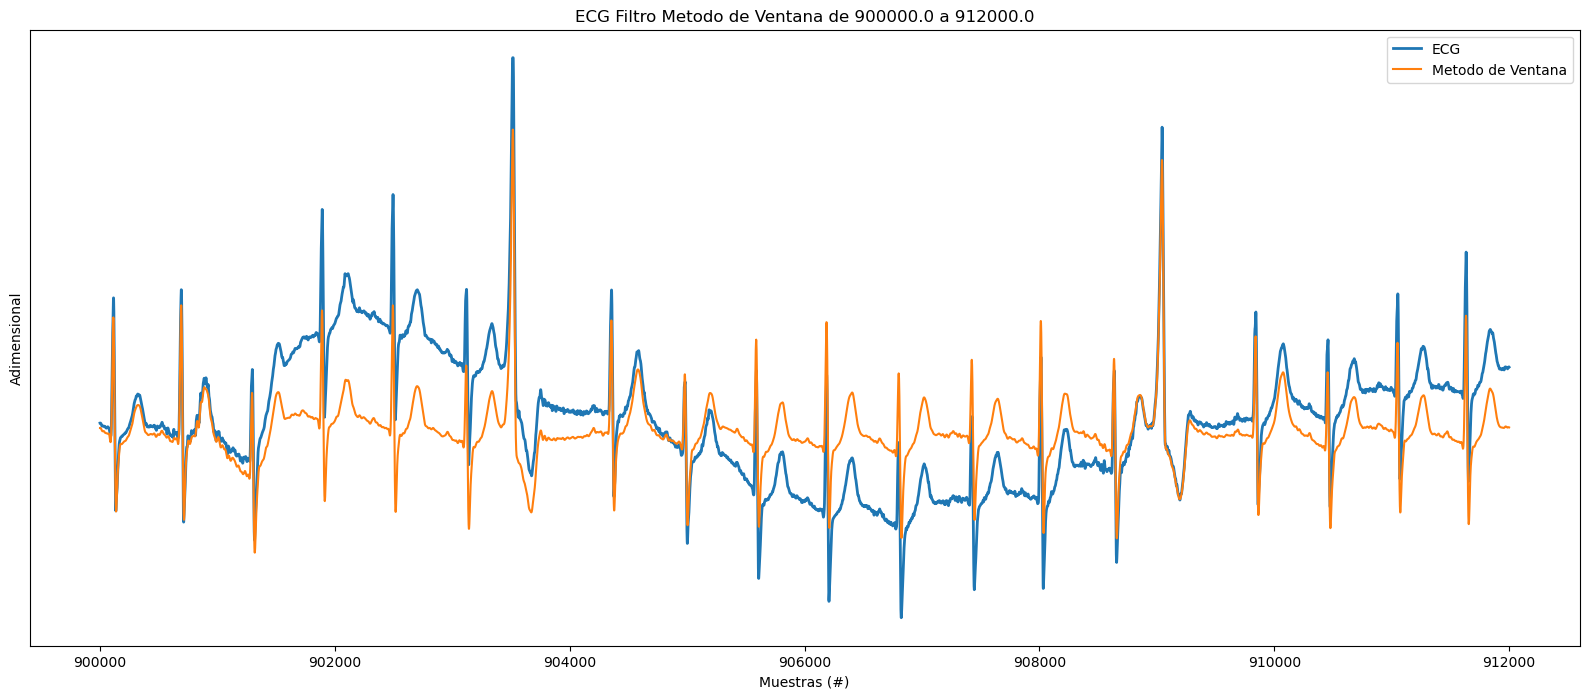

In [23]:
plot_ecg_filtered(ecg_one_lead,f_ecg_win,N,demora=(len(num_bp)-1)// 2,nombre_filtro ='Metodo de Ventana')

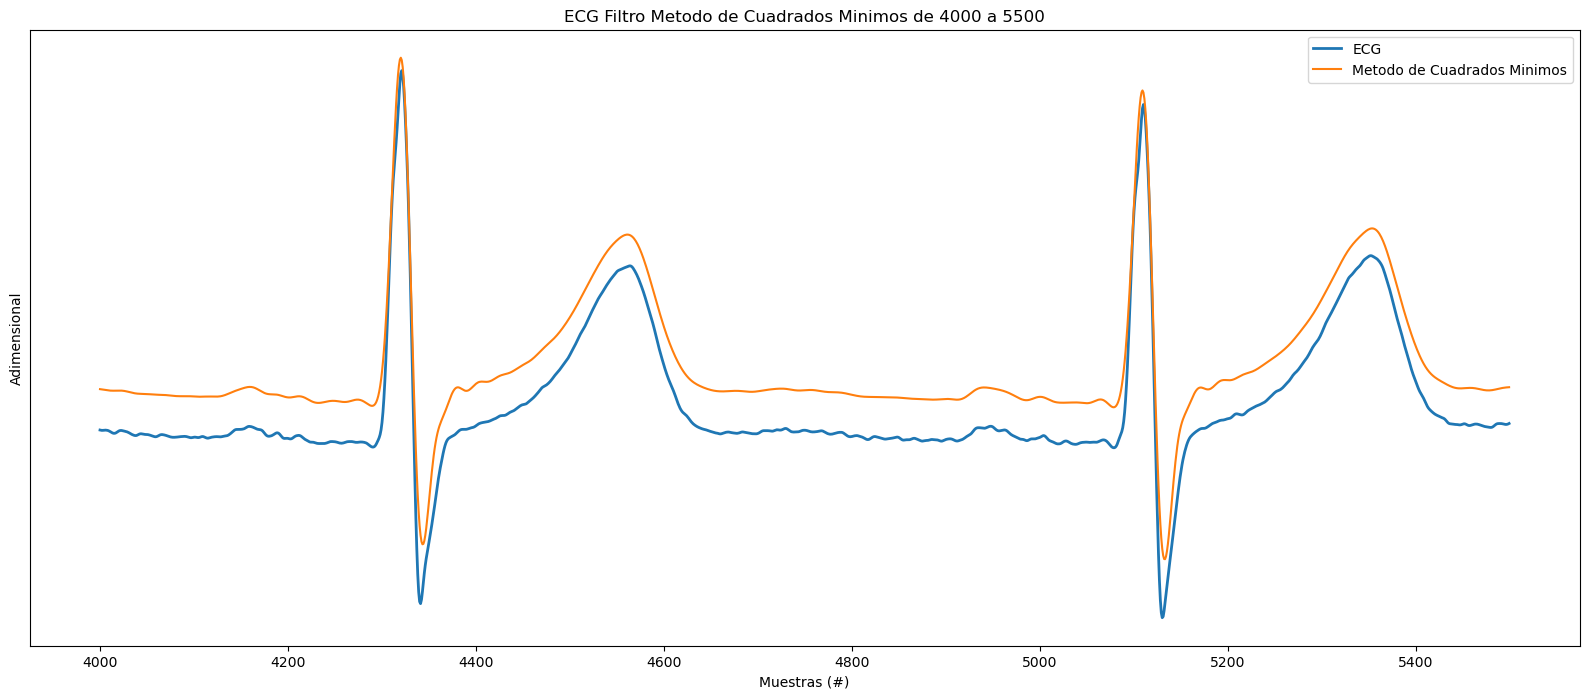

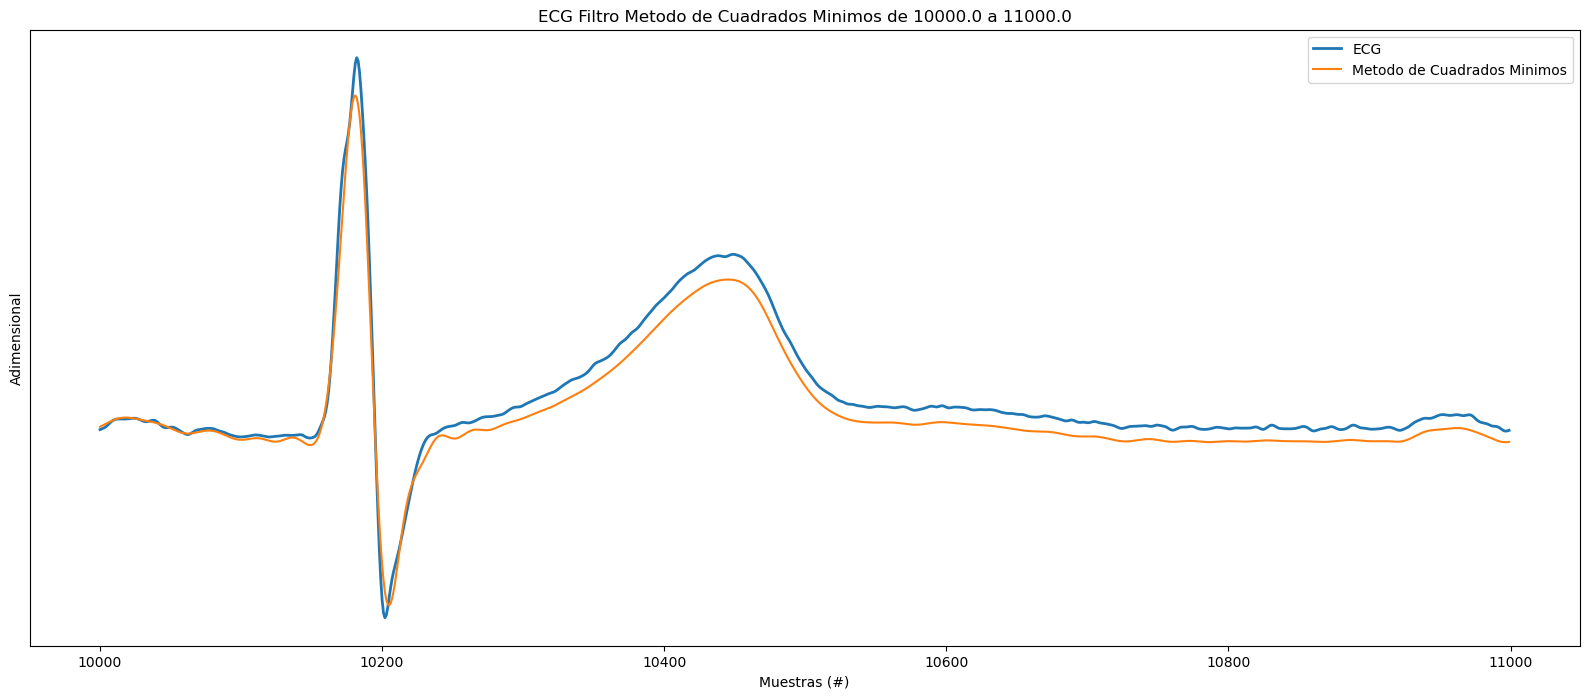

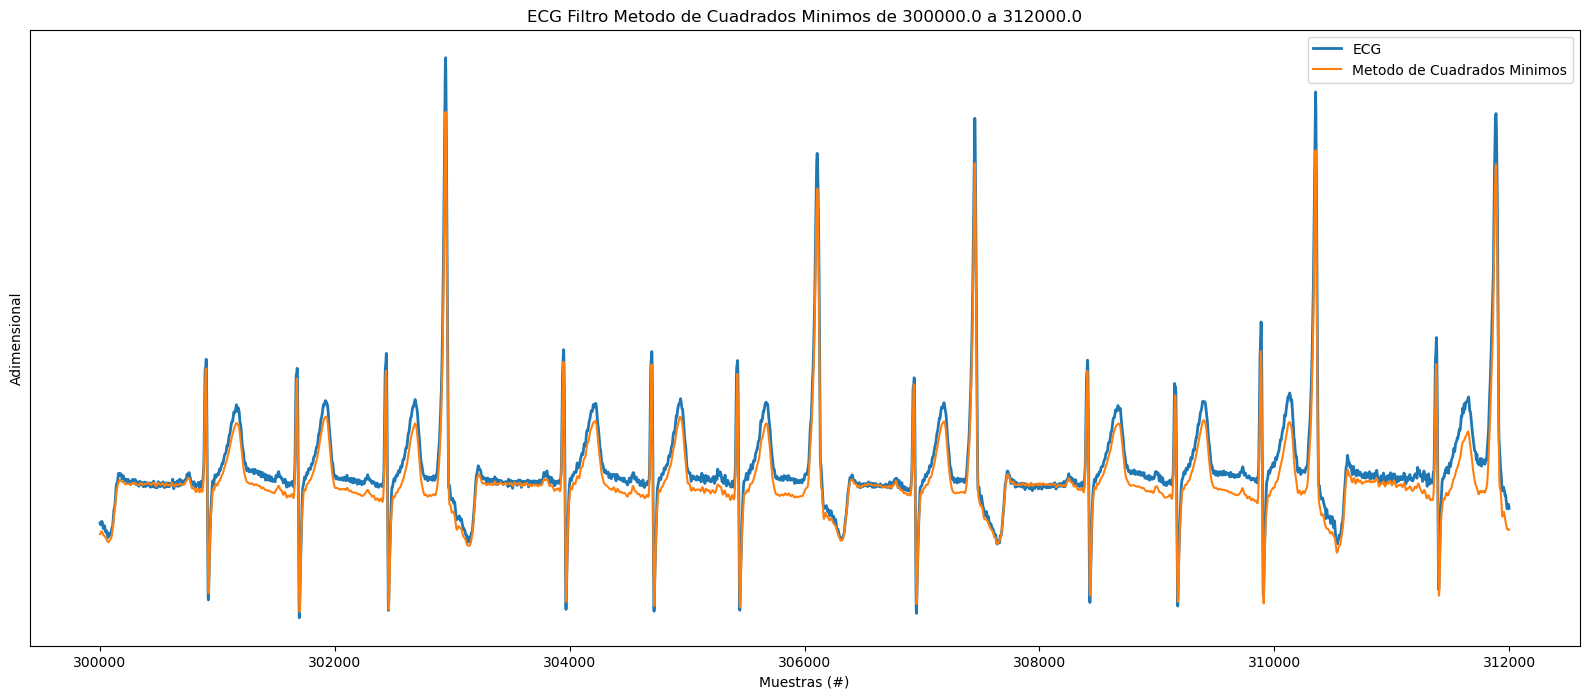

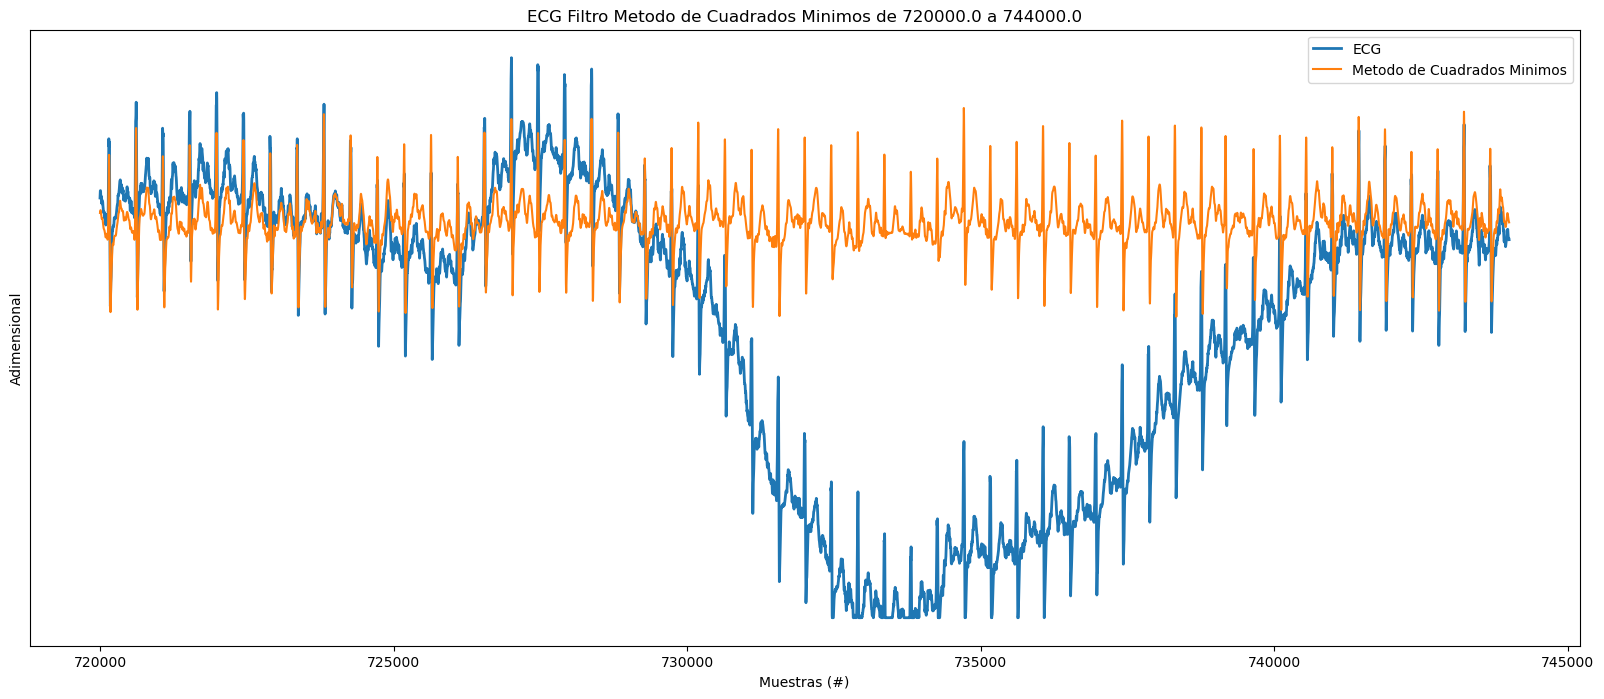

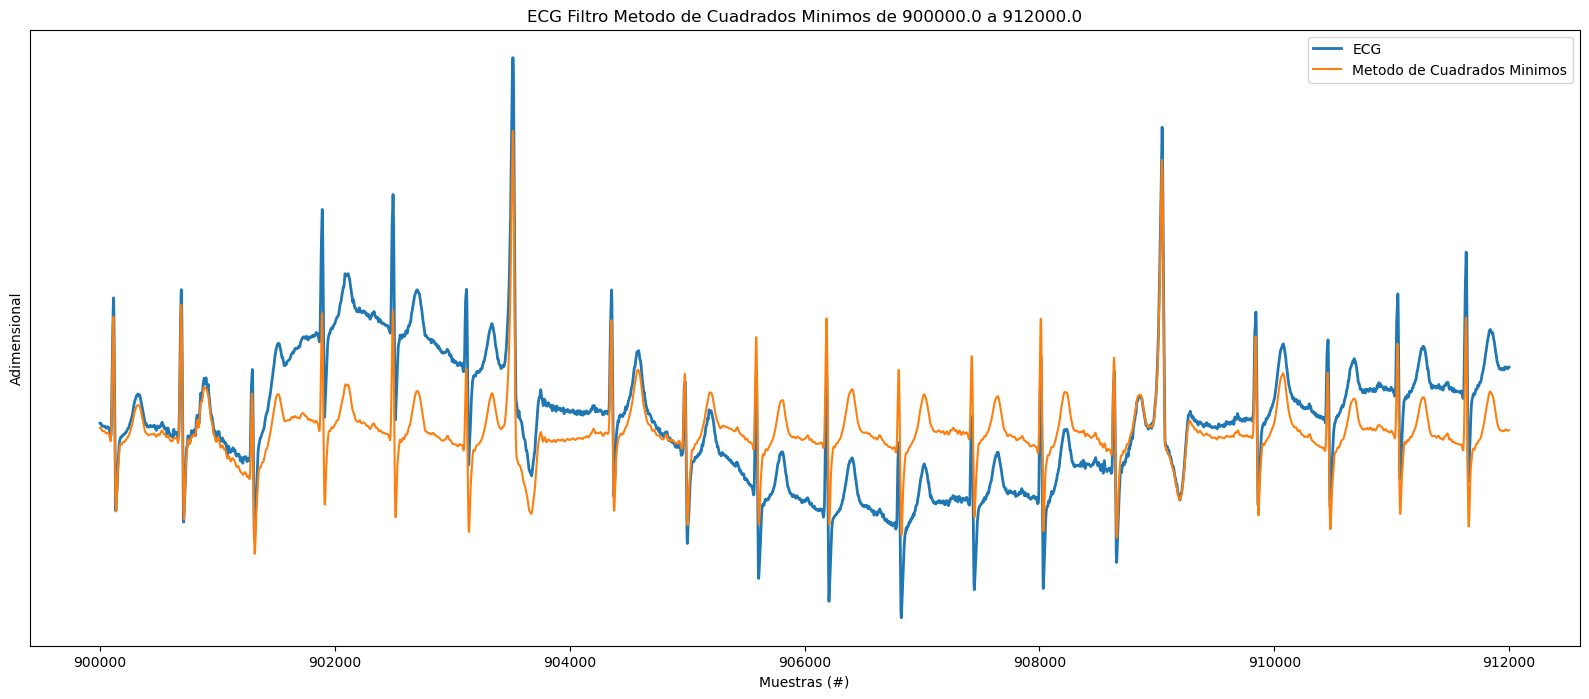

In [18]:
plot_ecg_filtered(ecg_one_lead,f_ecg_firls,N,demora=(len(firls_bp -1 )// 2),nombre_filtro ='Metodo de Cuadrados Minimos')

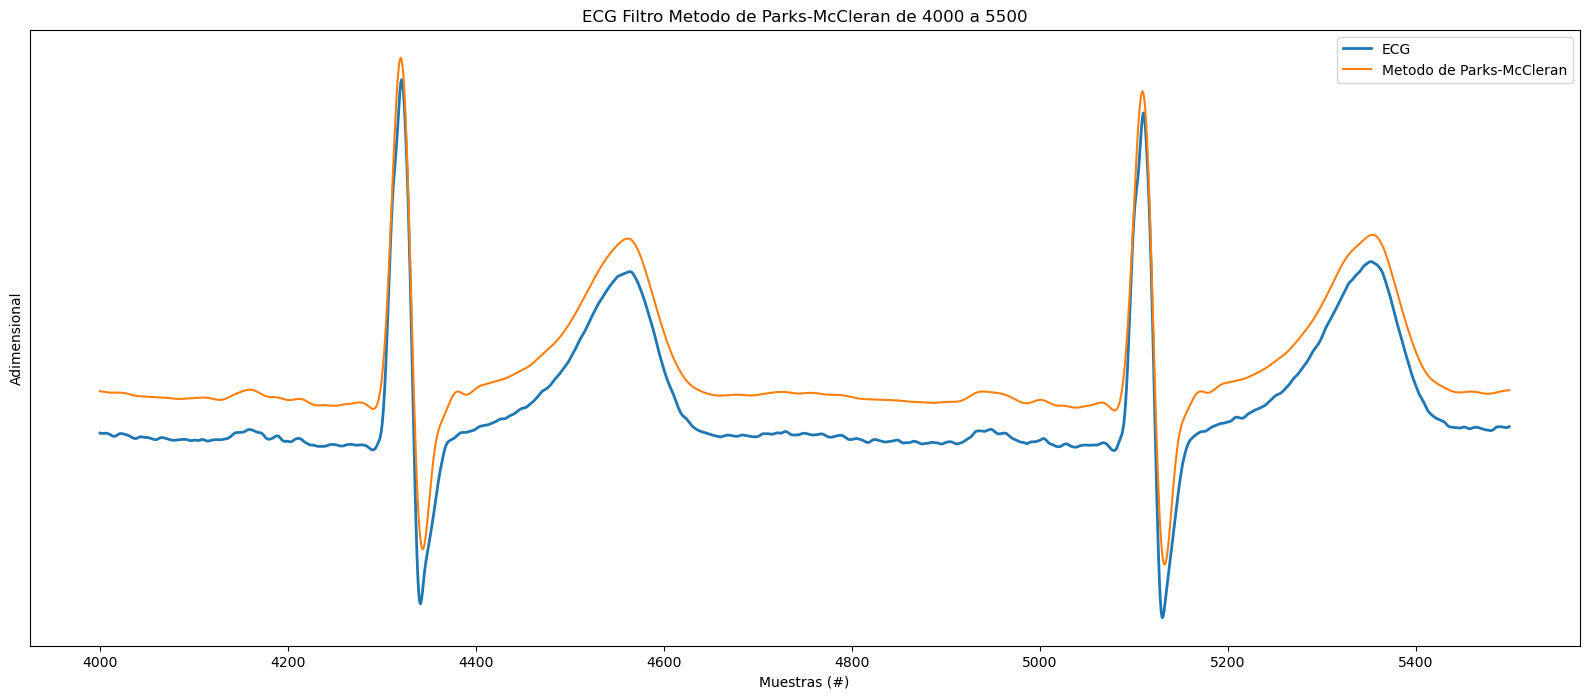

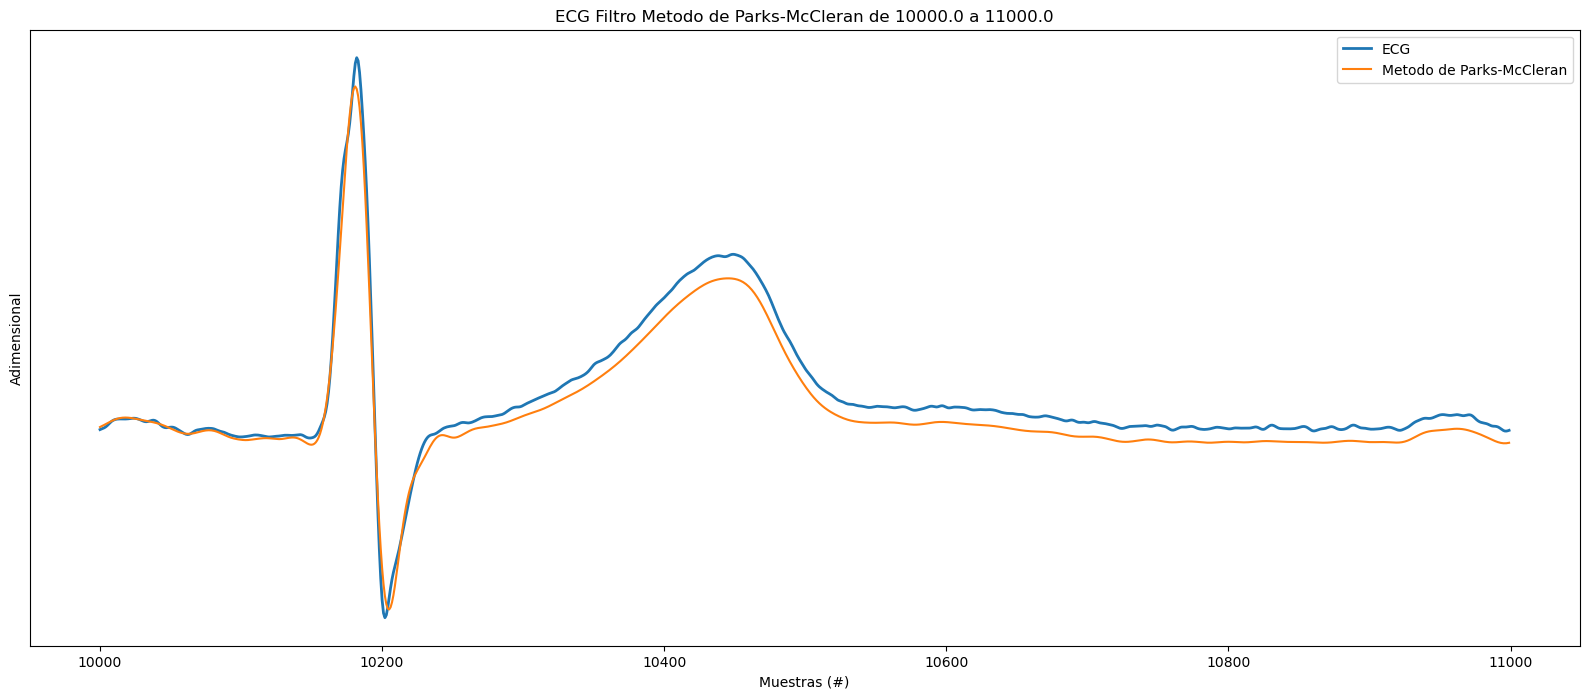

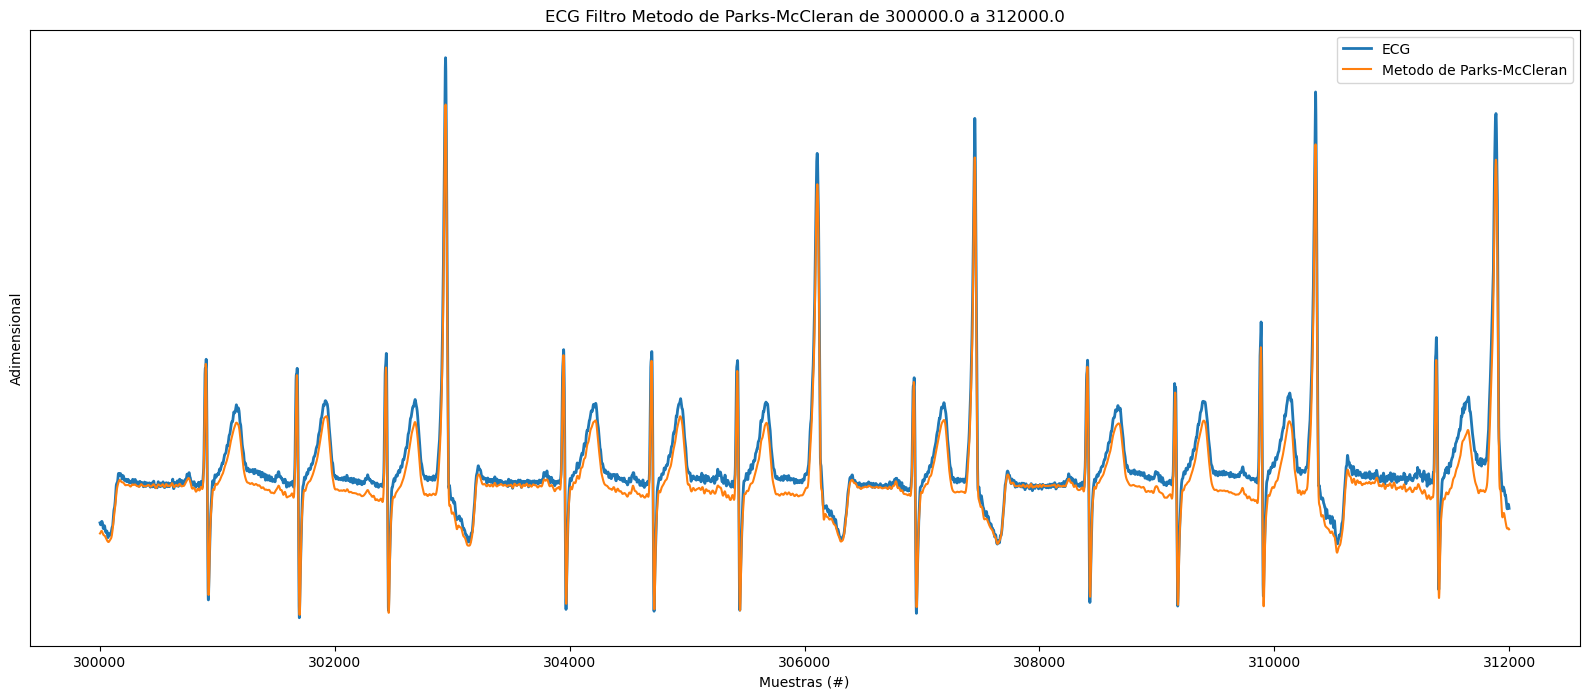

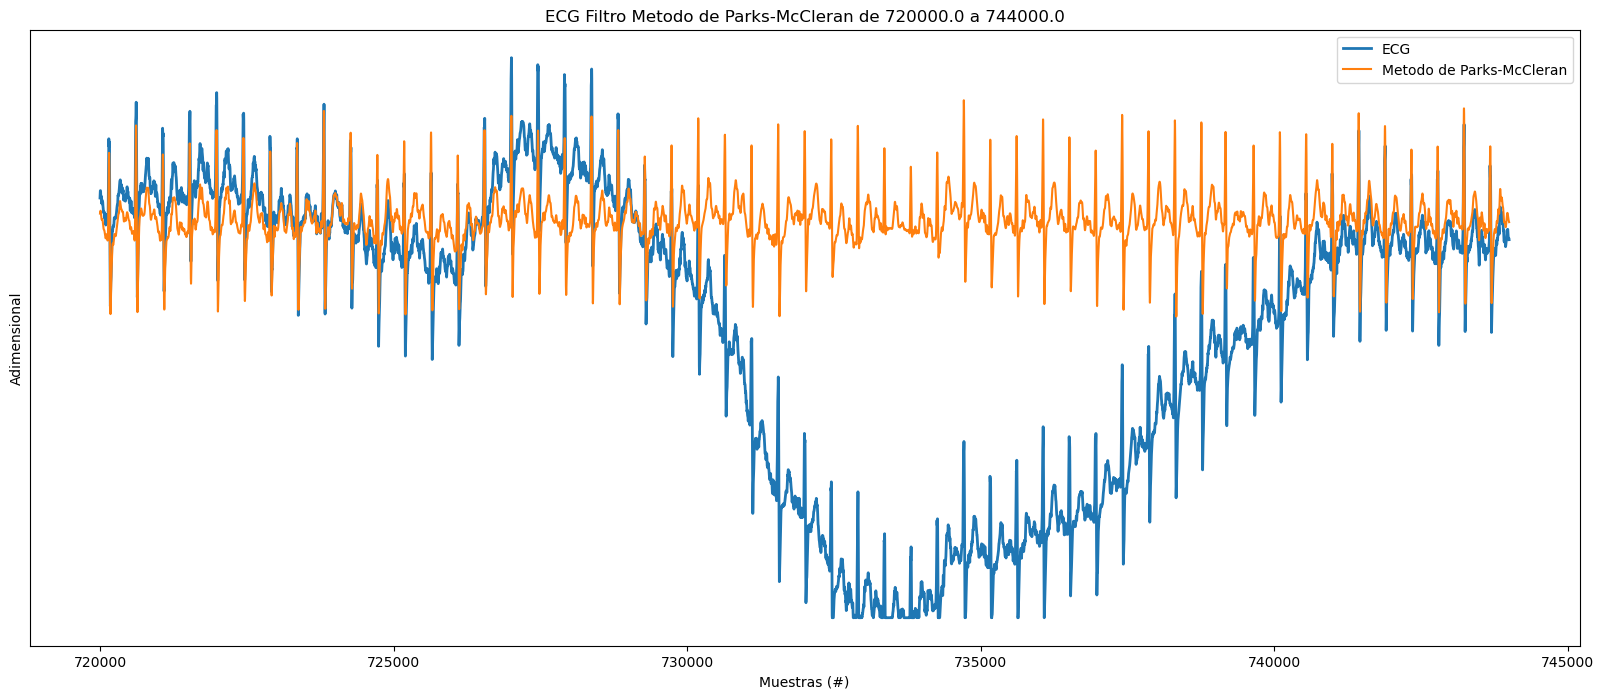

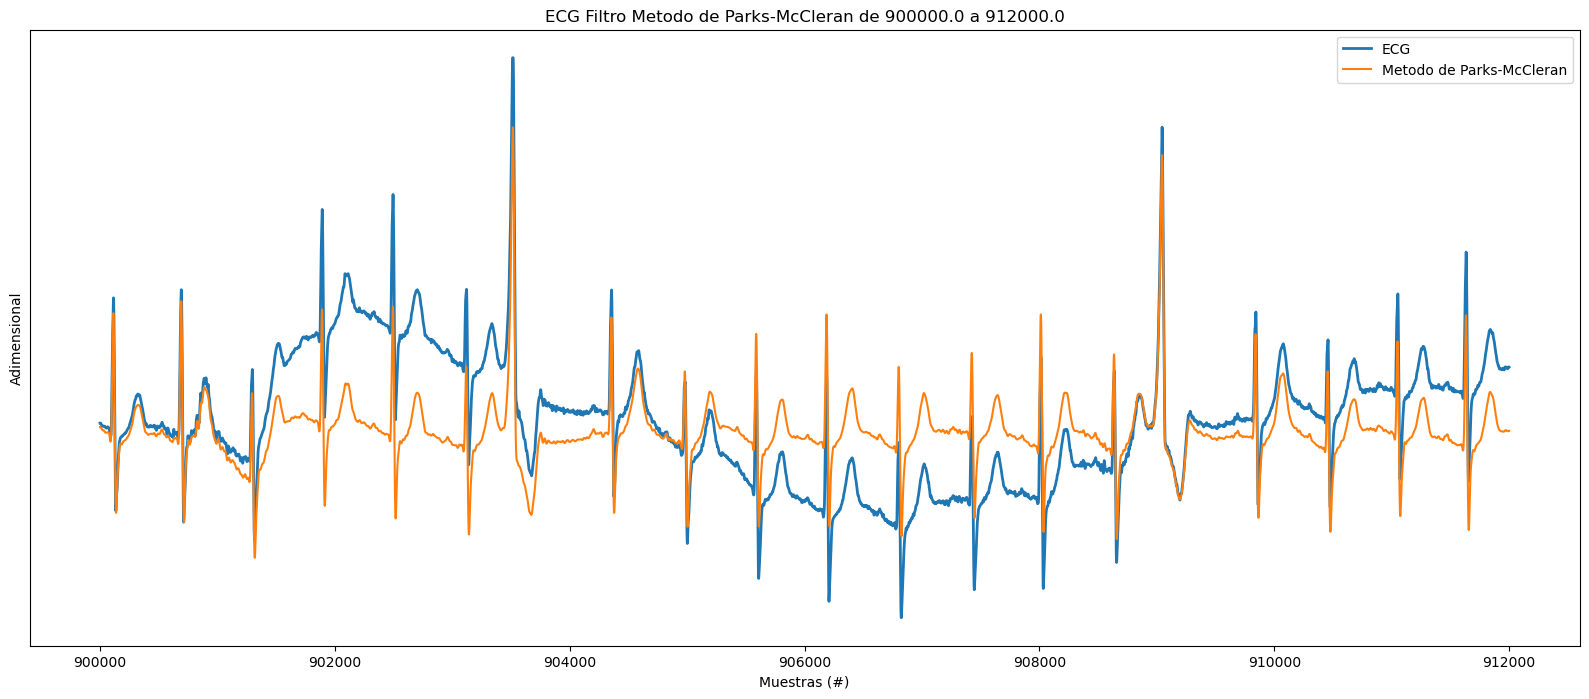

In [19]:
plot_ecg_filtered(ecg_one_lead,f_ecg_remez,N,demora=(len(remez_bp)-1)//2,nombre_filtro ='Metodo de Parks-McCleran')

Hacieno un pequeño analisis con respecto al filtrado FIR en las regiones donde se destacan 1 y 2 ciclos de ECG, se tiene que, primero a lo que se refiere como ruido de linea de base en los 3 metodos este fue practicamente eliminado, siendo el mejor el de PM, aunque no se encuentra tanta diferencia con los otros dos. Tambien podemos notar una suavidad en el pulso T, destacando la eliminacion de frecuencias altas en ellas.
Para las siguientes regiones, se nota nuevamente como se elimina la linea de base contaminada por ruido, se puede observar como hay un pequeño retardo de grupo en todo el filtrado, algo esperado ya que no fue filtraedo dos veces en sentidos diferentes (No se uso filtfilt). Pero hubo una correccion en la demora al momento del muestreo

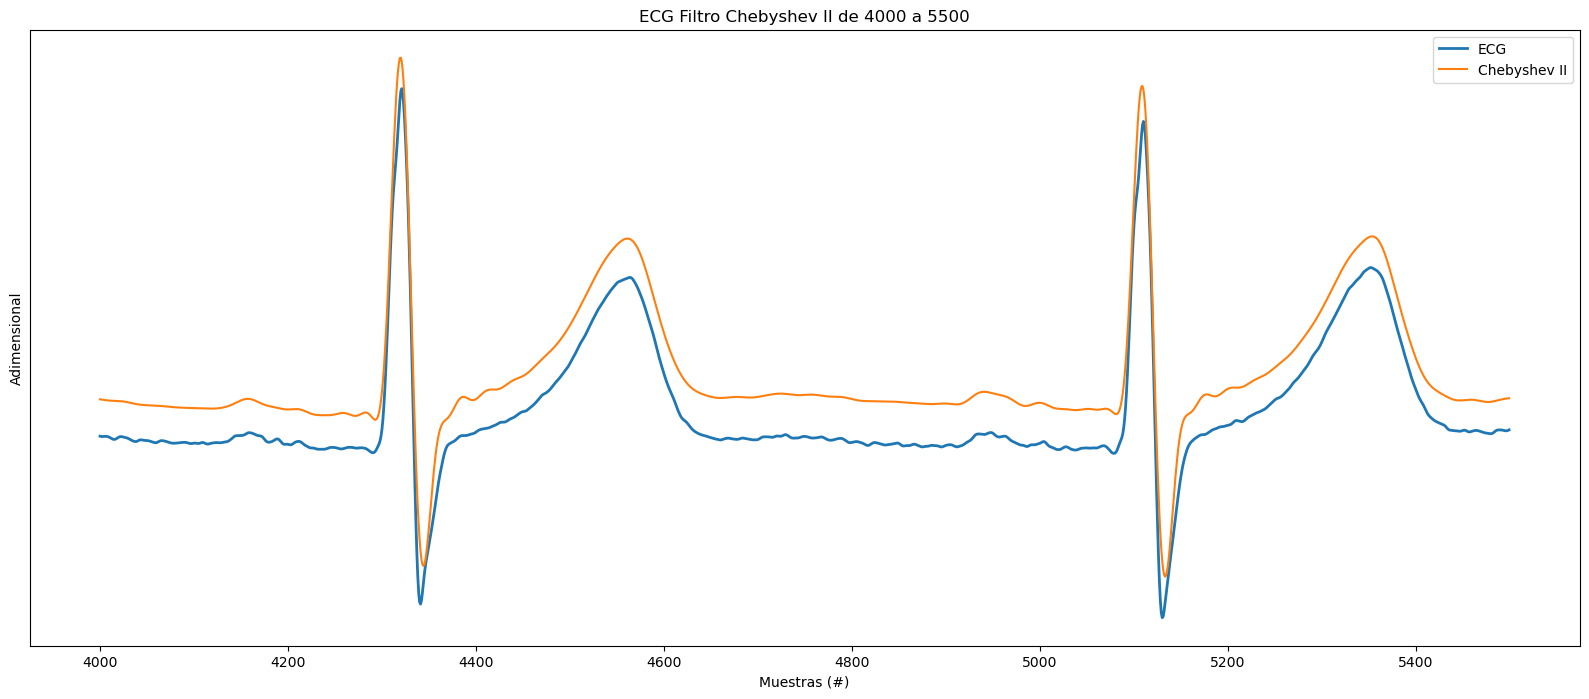

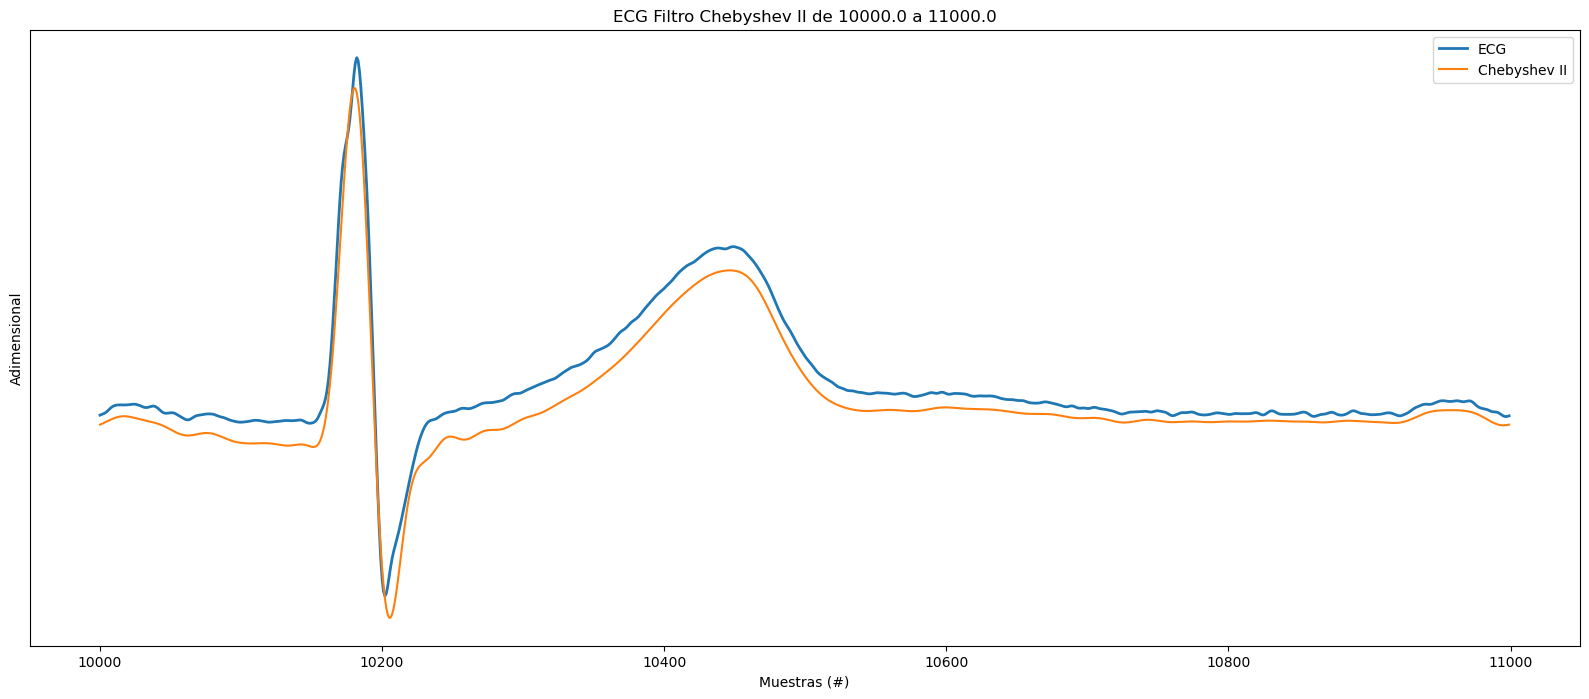

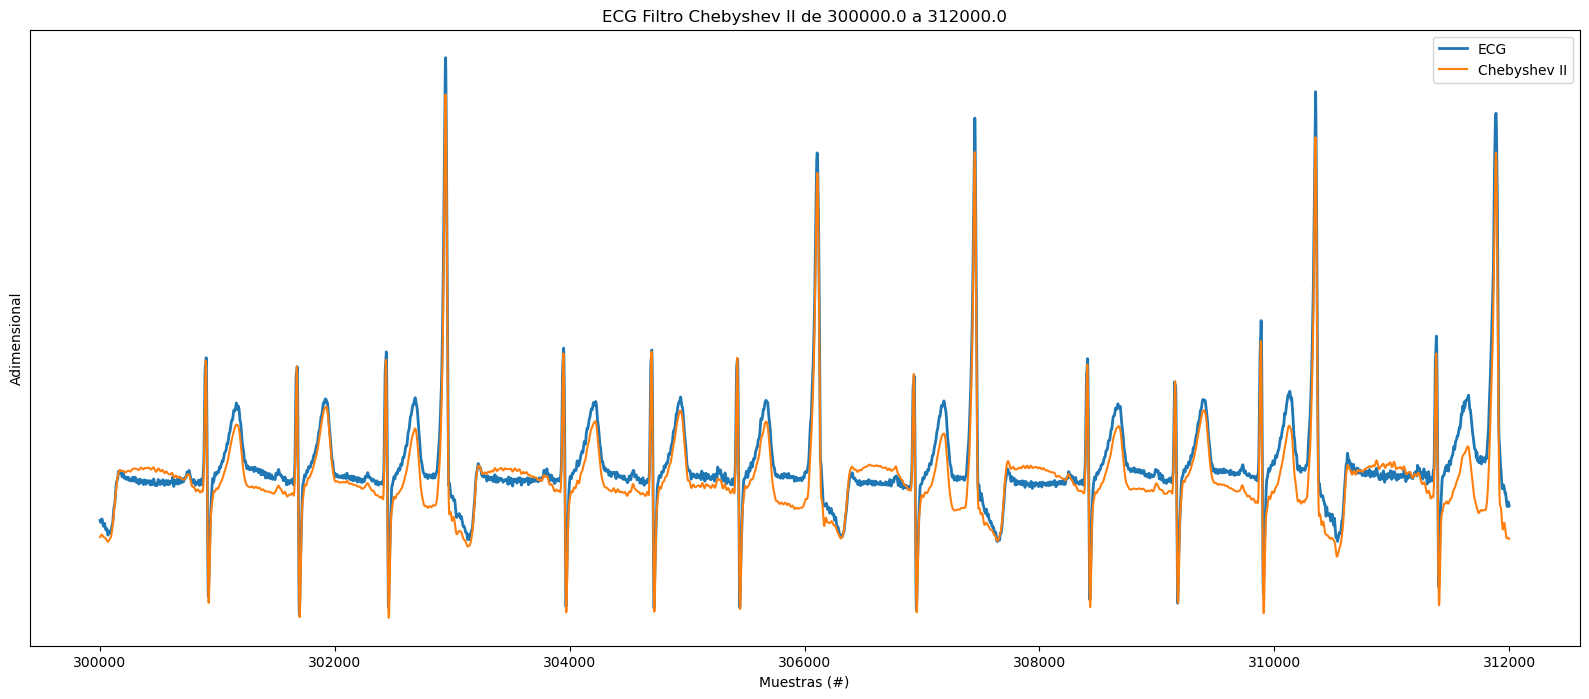

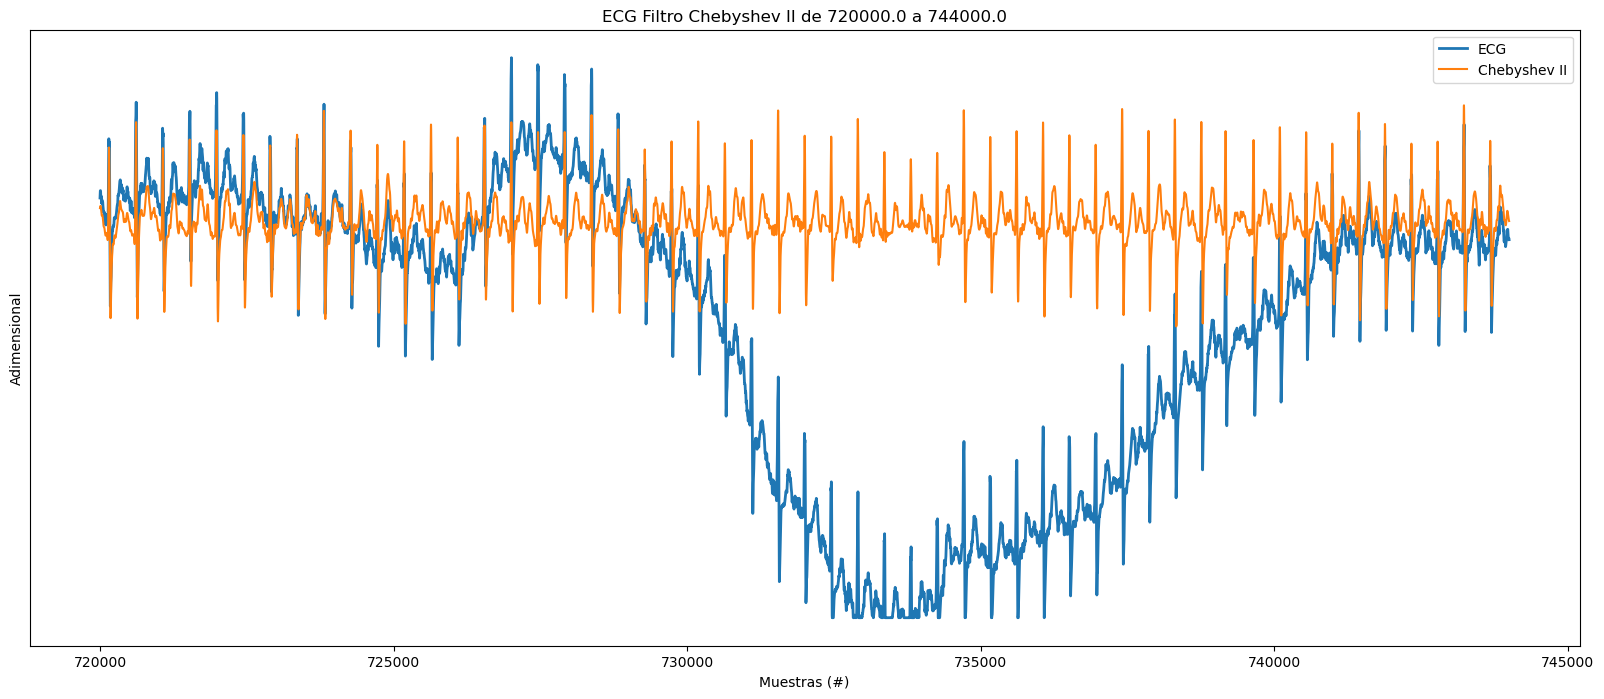

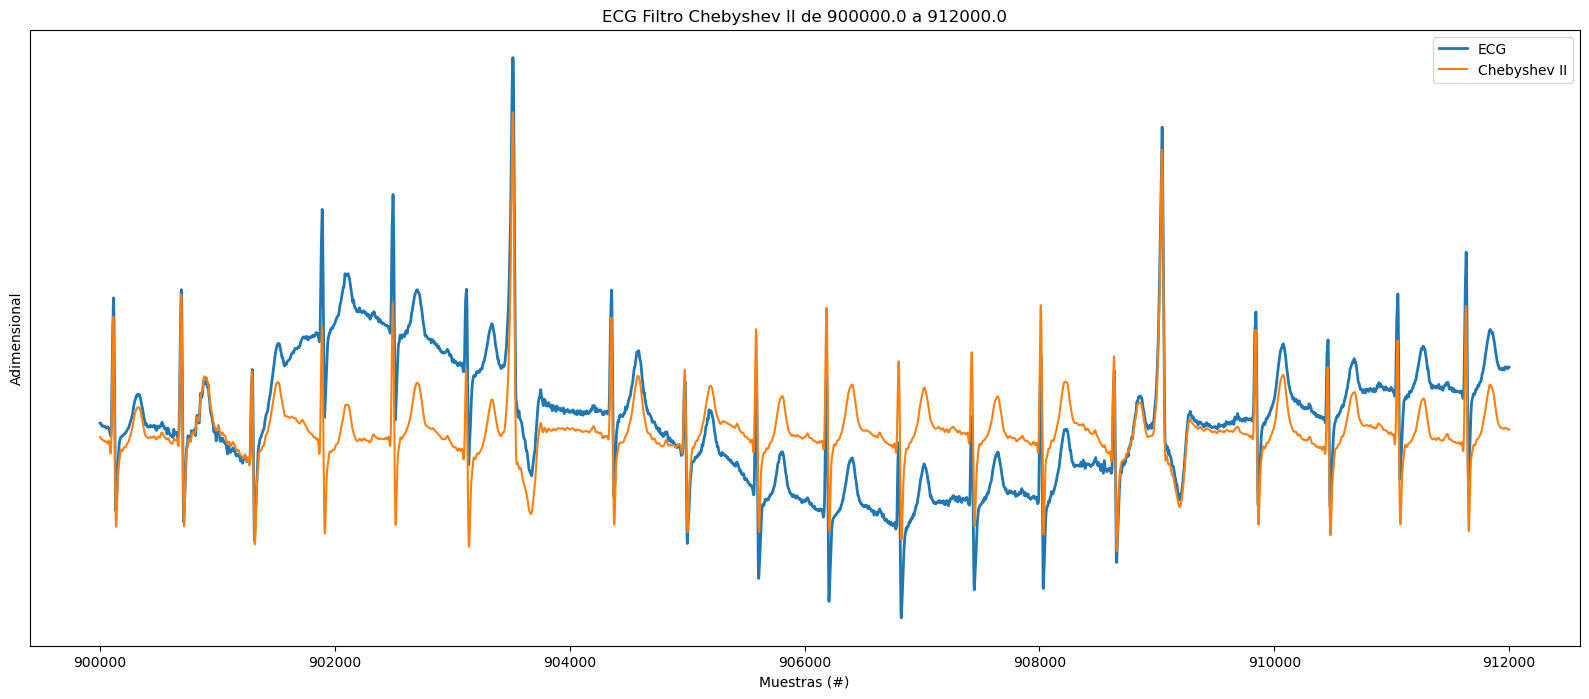

In [20]:
plot_ecg_filtered(ecg_one_lead,f_ecg_cheby2,N,demora=0,nombre_filtro ='Chebyshev II')

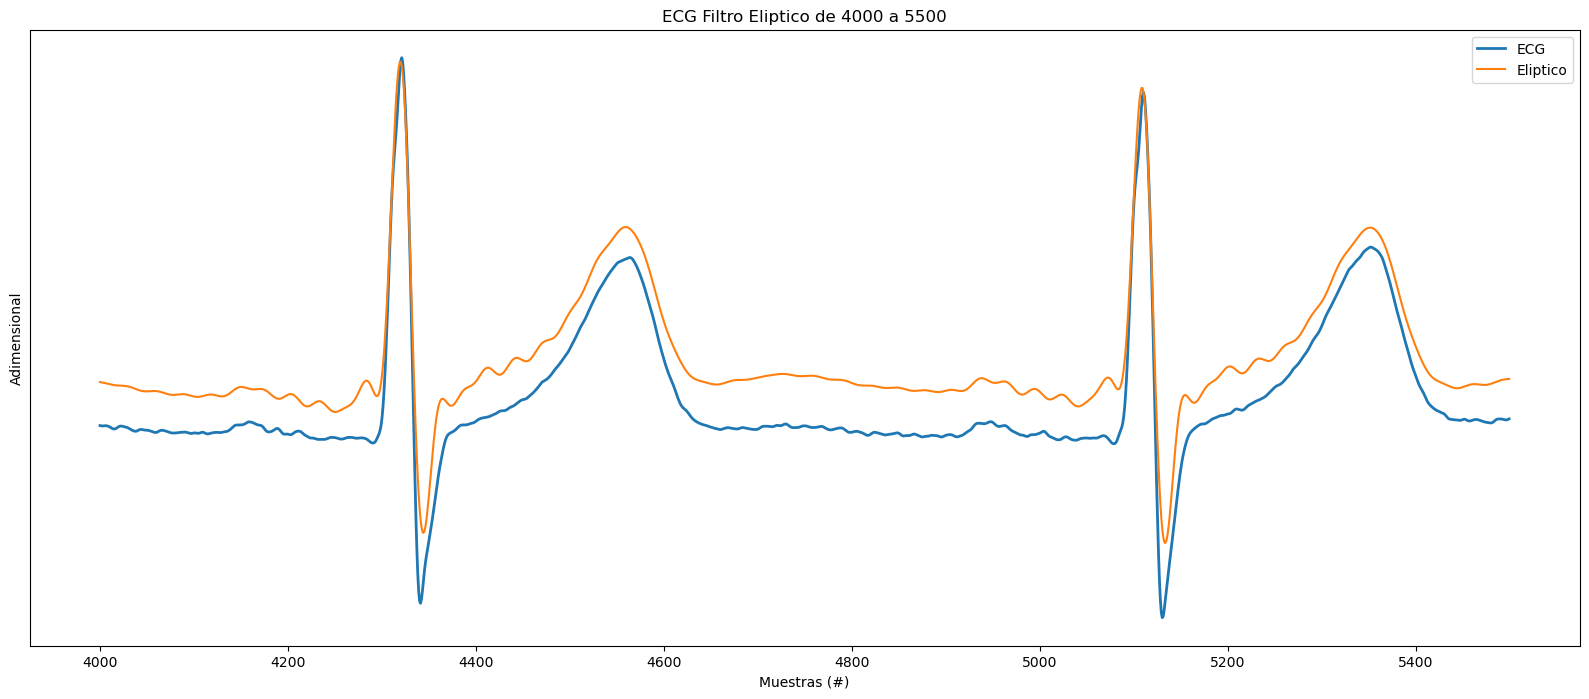

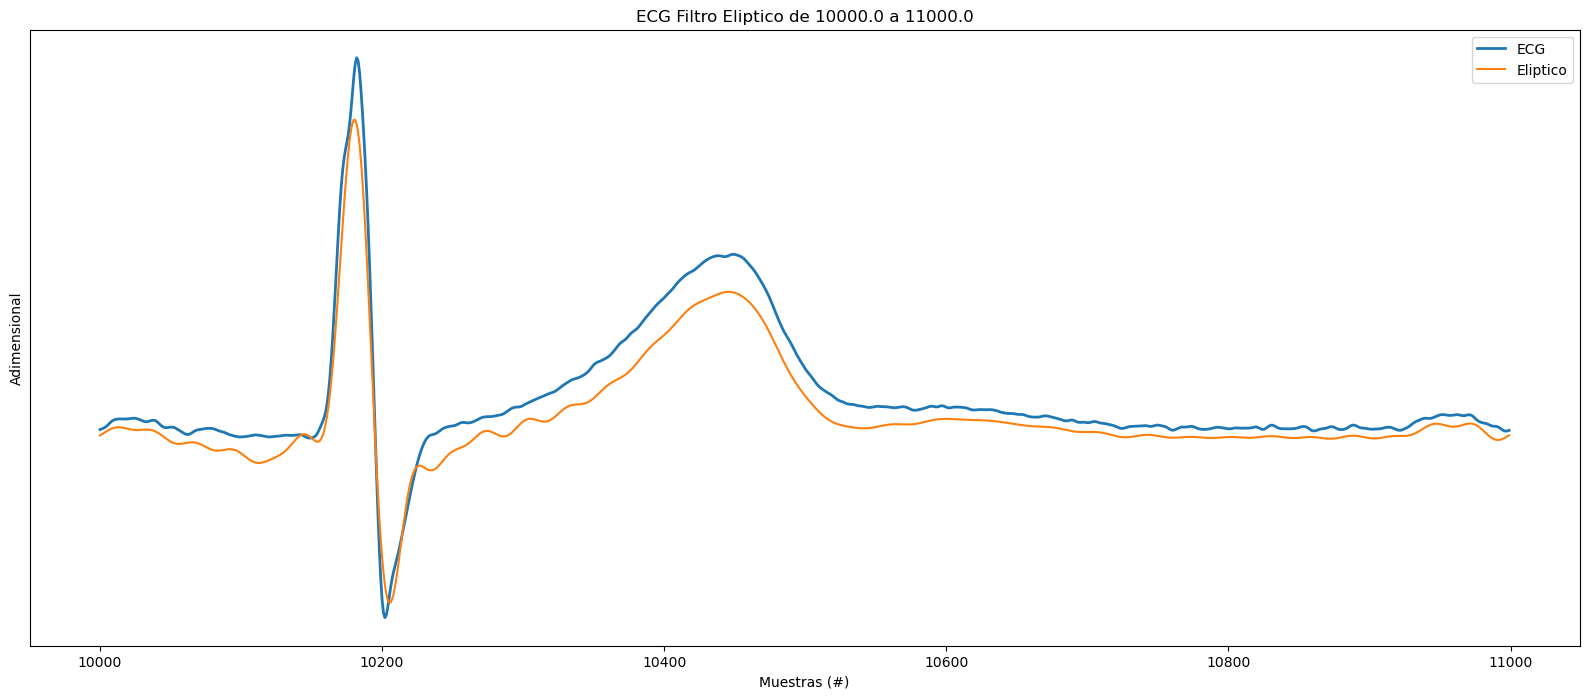

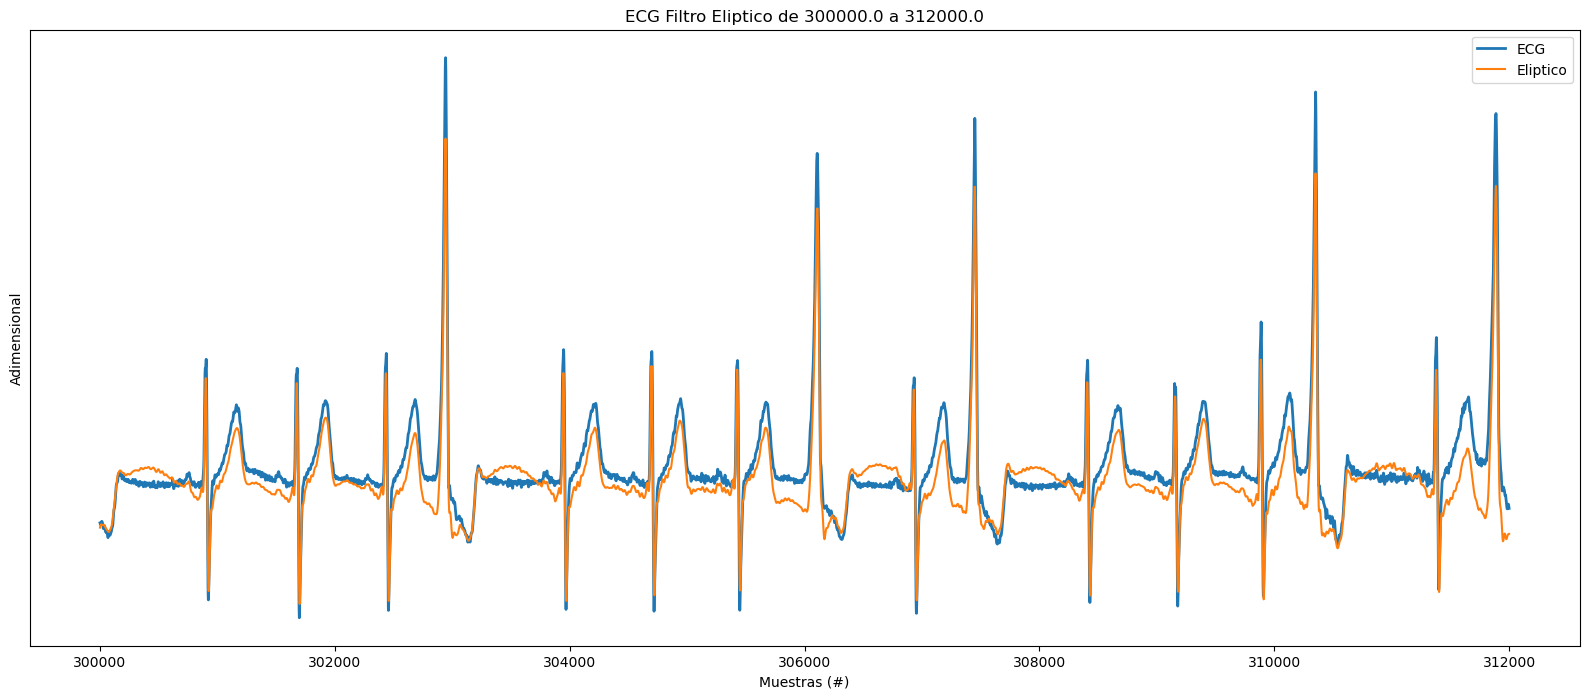

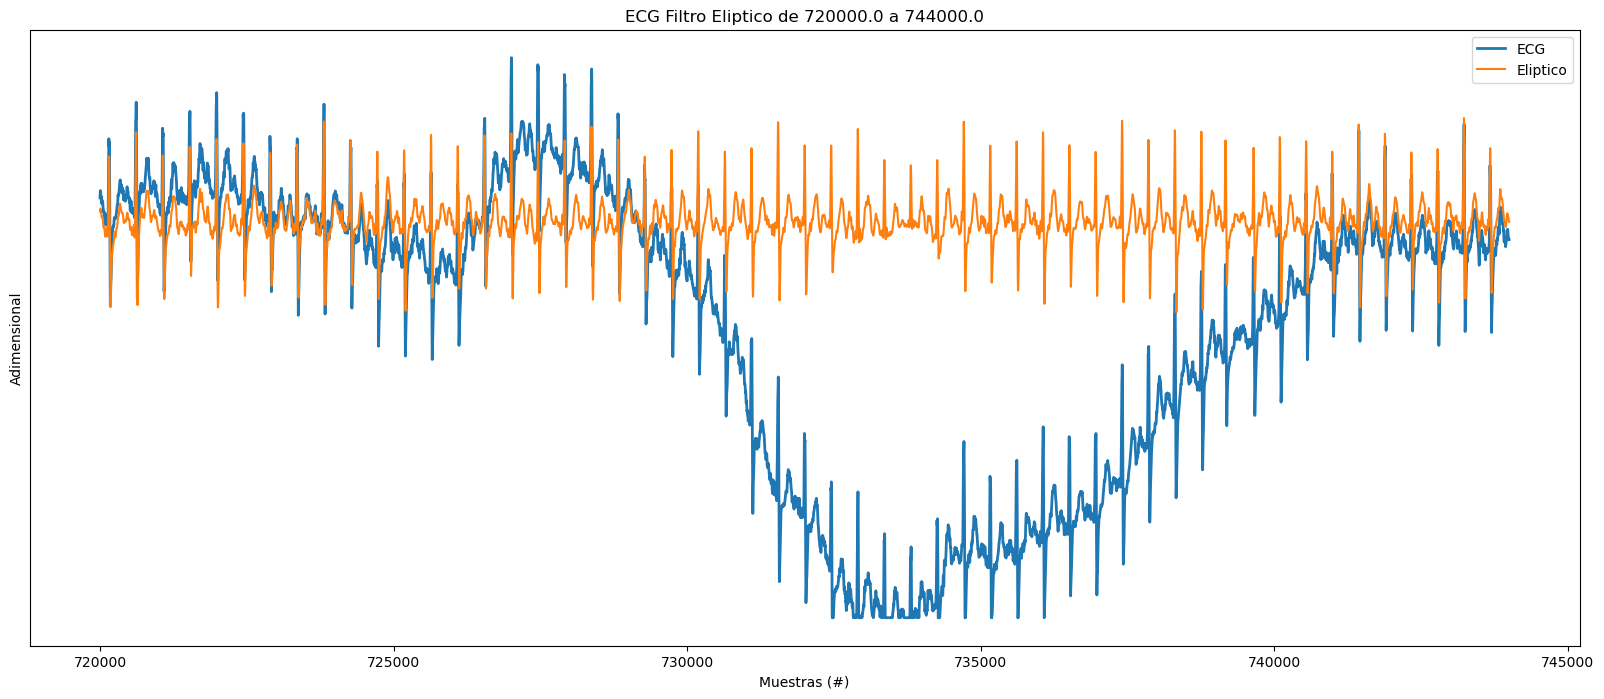

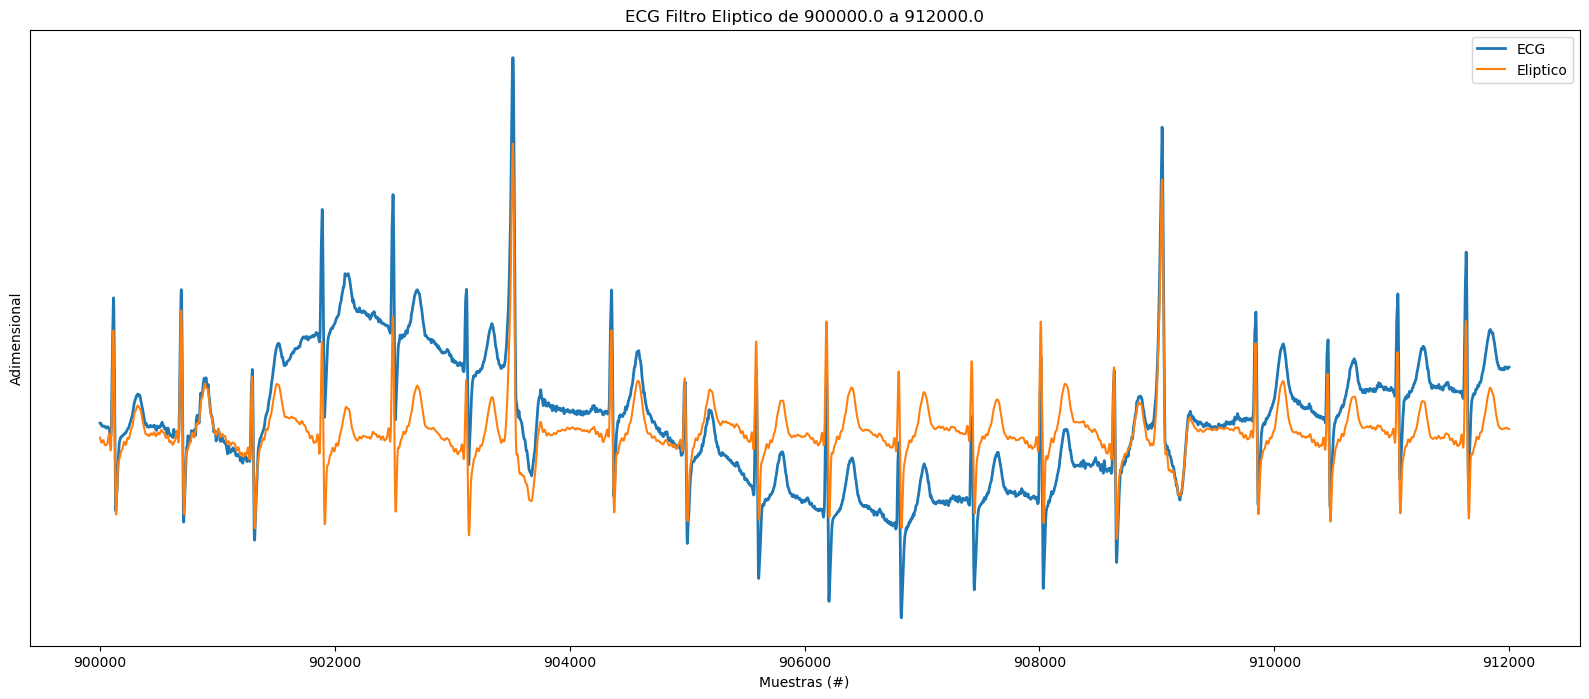

In [21]:
plot_ecg_filtered(ecg_one_lead,f_ecg_ellip,N,demora=0,nombre_filtro ='Eliptico')

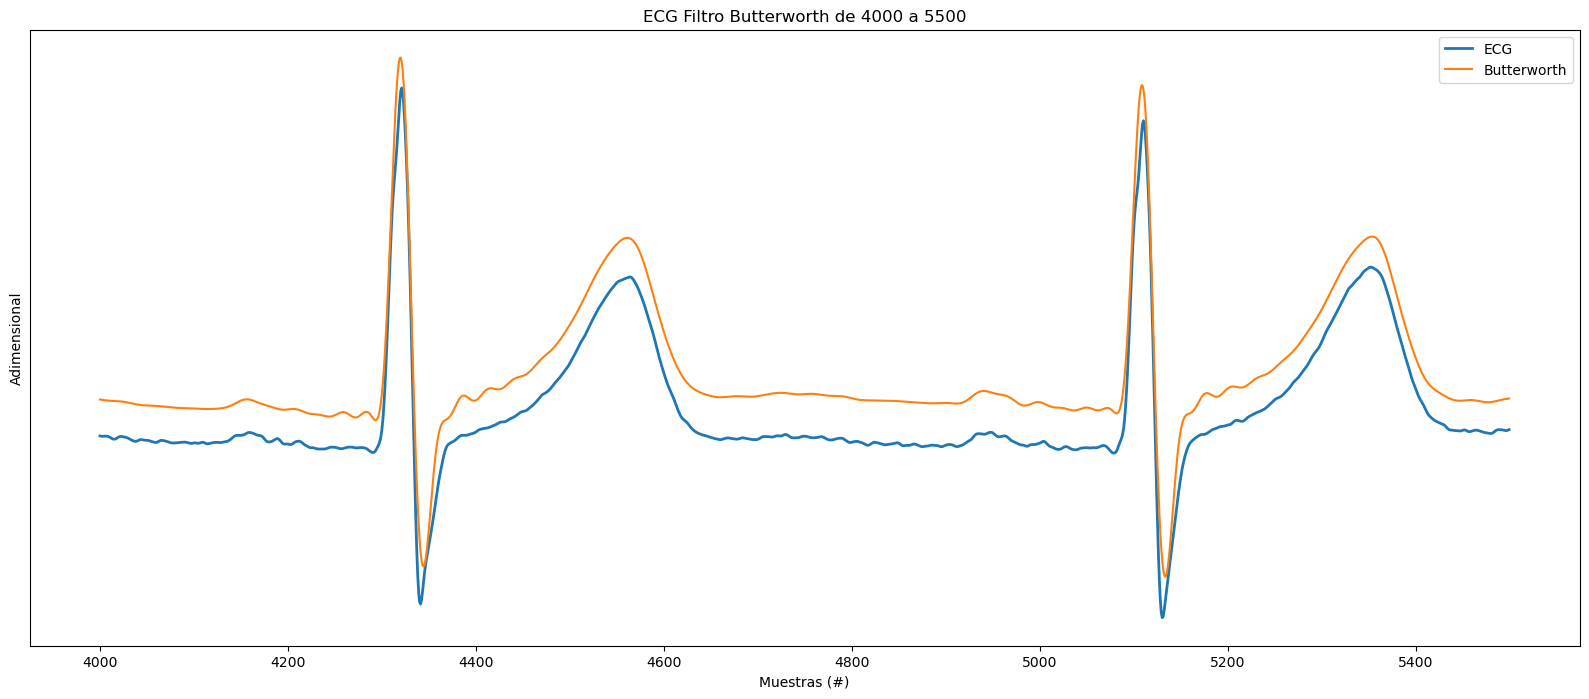

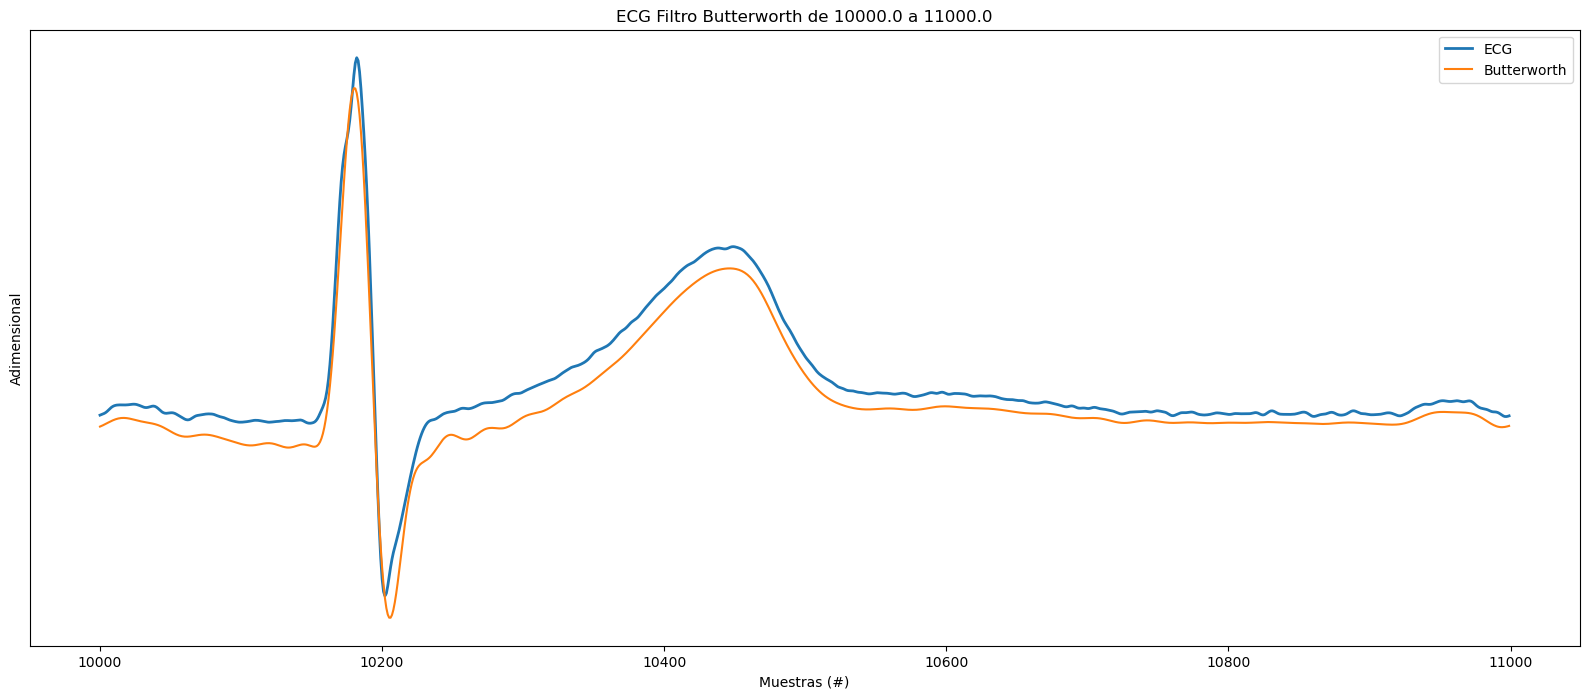

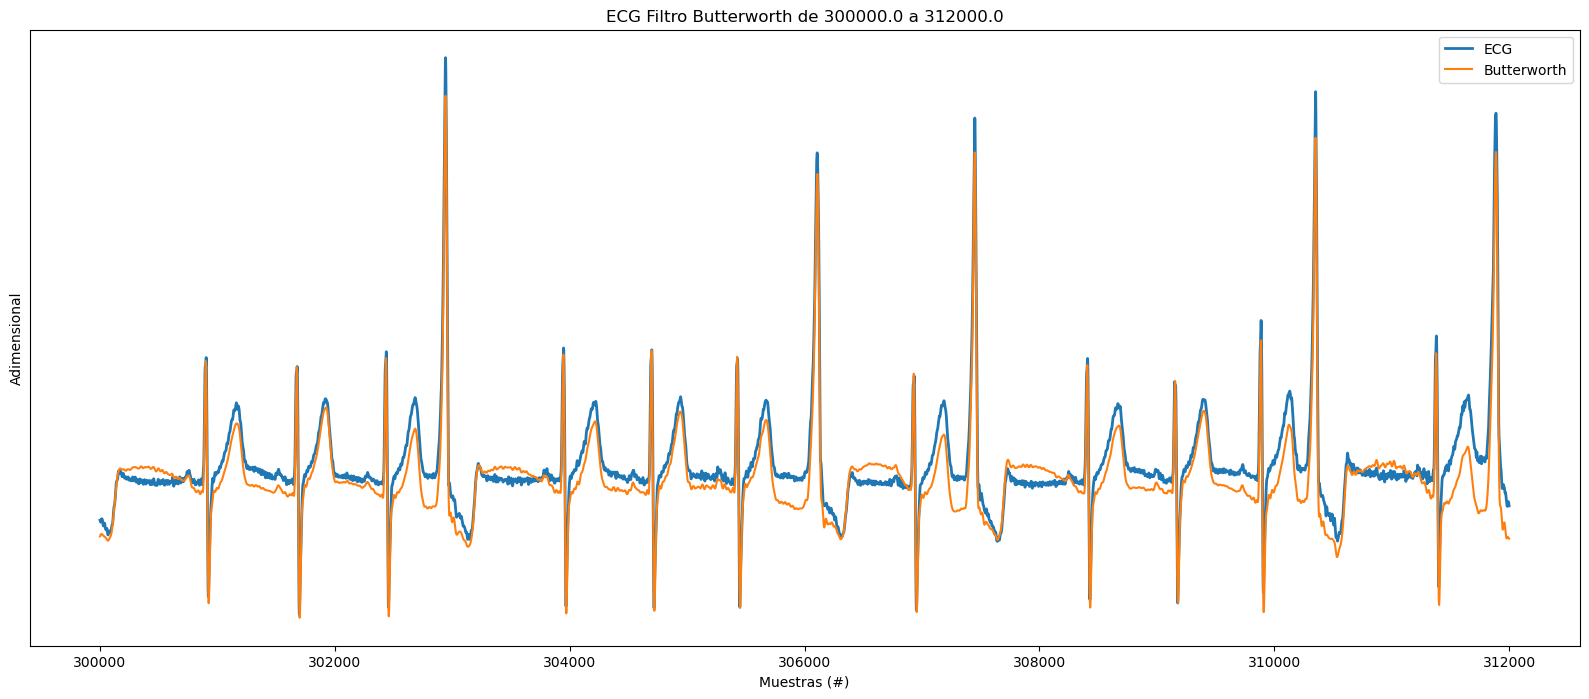

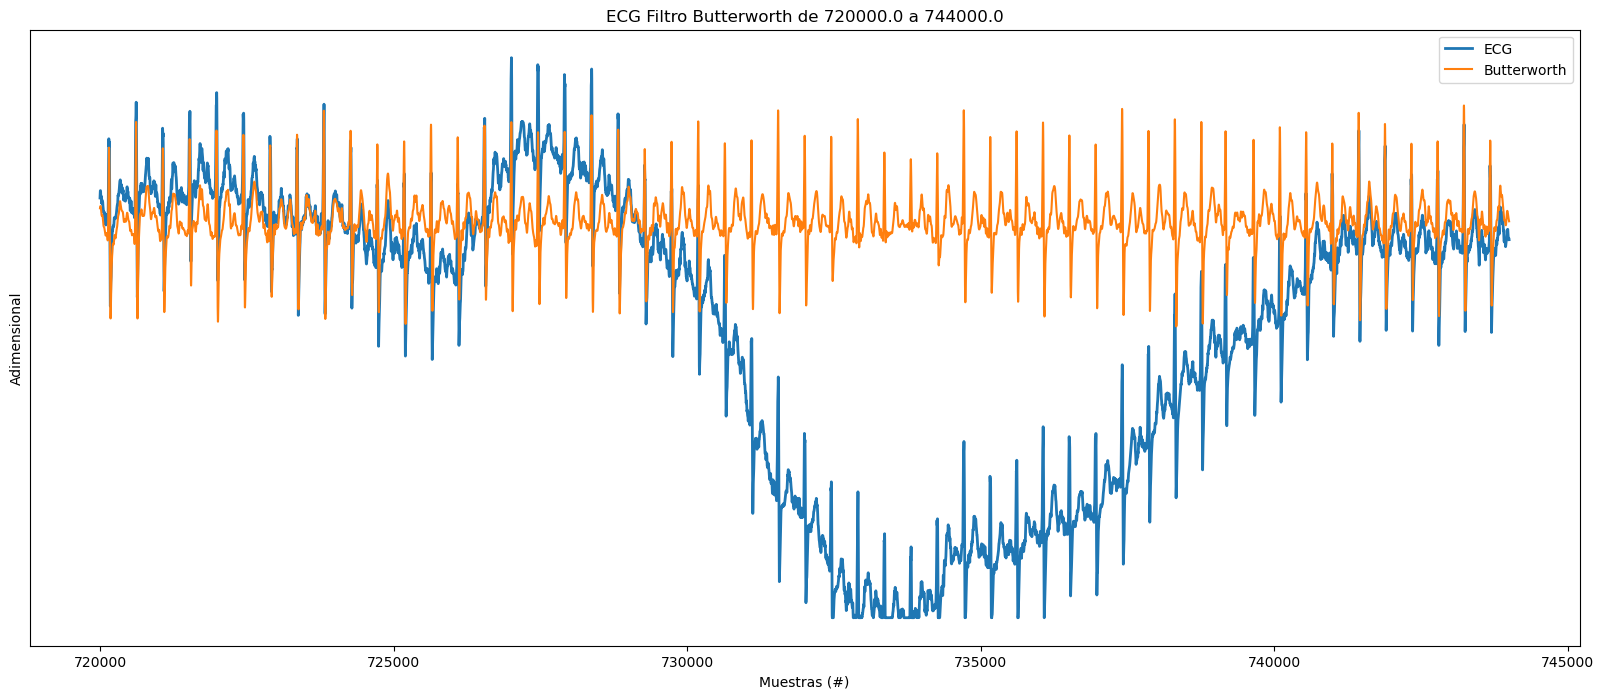

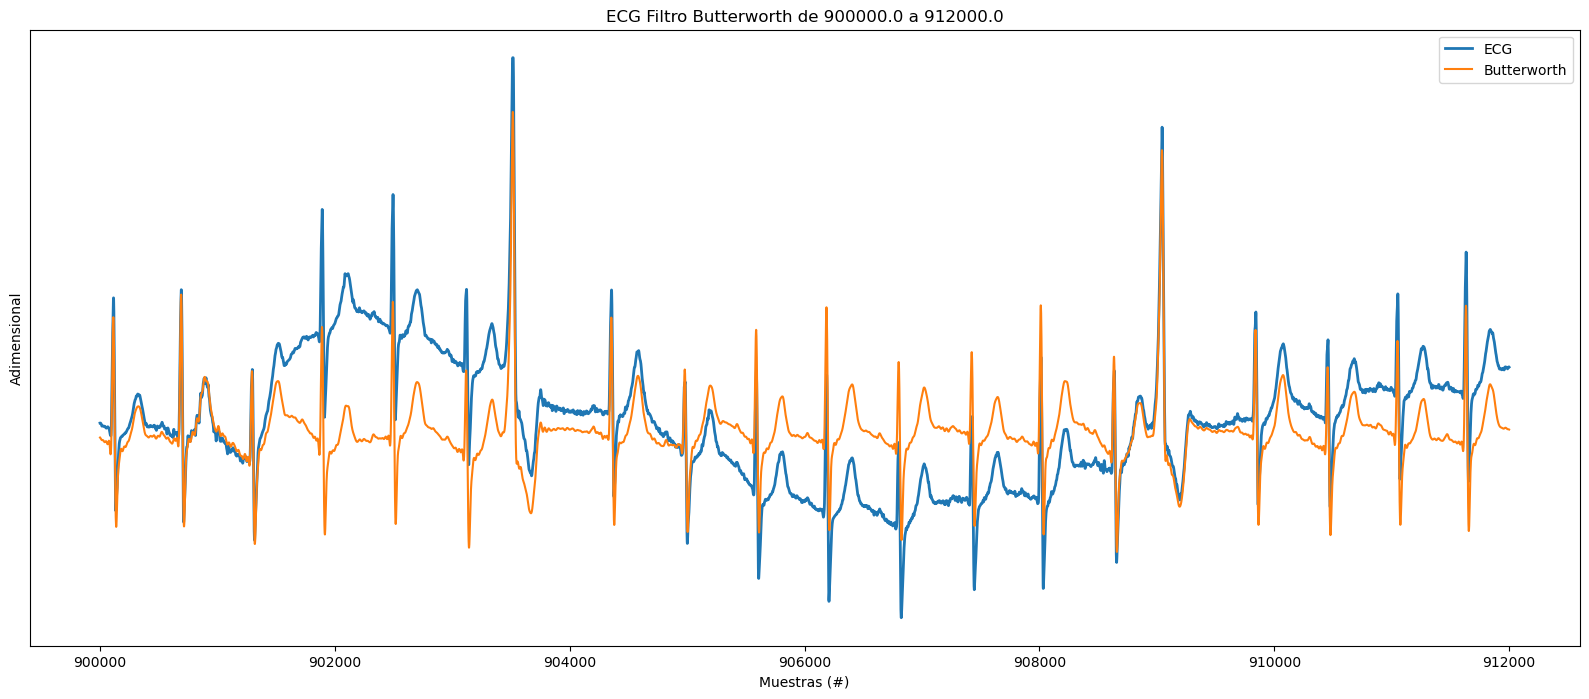

In [22]:
plot_ecg_filtered(ecg_one_lead,f_ecg_butter,N,demora=0,nombre_filtro ='Butterworth')

Si hacemos un contraste con los filtros FIR, podemos notar lo mas destacable en general es que no sufre una demora, ya que al filtrarlo mediante "filtfilt" se elimino la distorcion de fase y el retardo de grupo. En lo que corresponde a las frecuencias de altas se nota como la onda T en ambos metodos se suaviza, sin embargo en busca de eliminar frecuencias bajas este no resulta igual de efectivo que los FIRs, se nota como el segmento ST presenta oscilaciones y con una pendiente menos abrupta. ademas que en la transicion hacia el pulso P este no presenta una suaividad constante. Si es capaz de eliminar ruido de linea de base en todo el registro. 

# Conclusiones

Se pudo diseñar una plantilla de filtrado para una señal ECG con interferencias presentes, en donde ademas se puso en practica las diferencias entre los filtros FIR e IIR, que estos en cierta manera demostraron ser un desafio a la hora del armado, principalmente los FIR al aplicar muchos conceptos vistos en clases anteriores y el hecho de la necesidad de tener que combinar dos tipos distintos para que se llegue al resultado final. Se pudo tambien filtrar la señal mediante funciones propuestas por scipy.signal y ademas se pudo hacer una verificacion de los filtros, en el cual se puede concluir que dependiendo de la informacion que quieras captar la informacion, resultara mas efectivo un tipo que el otro.Por lo general se puede eliminar las interferencias de baja y altas frecuencias, sin embargo se puede aplicar otros metodos para la elimniacion de la linea de base ocasionado por el ruido.No obstante en general se puede aproximar a una replica de la señal teorica, si se usa el metodo PM teniendo en cuenta sus ventajas y desventajas.